<a href="https://colab.research.google.com/github/GiX7000/computer-vision-on-CIFAR-10-from-basics-to-transformers/blob/main/7_custom_vision_transformer_vs_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPU

We manually switch to a GPU device on Colab by clicking `Runtime -> Change runtime type` and selecting `GPU` under `Hardware Accelerator`.

## Setup

Having switched to GPU, we start running the following cells to import packages.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as datasets
import torchvision.transforms as T

import numpy as np
import math
from tqdm import tqdm

USE_GPU = True
dtype = torch.float32 # We will be using float throughout this tutorial.

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss.
print_every = 100
print('using device:', device)

using device: cuda


# Preparation and Visualization

## Load CIFAR-10 dataset

Now, let's load the CIFAR-10 dataset. PyTorch provides some convenient tools to automate this process even more for us.

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define the mean and standard deviation for CIFAR-10.
mean = (0.4914, 0.4822, 0.4465)  # Precomputed mean for CIFAR-10.
std = (0.2023, 0.1994, 0.2010)   # Precomputed std for CIFAR-10.

# Define the transform for preprocessing and data augmentation.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Load the CIFAR-10 dataset
dataset_path = '/content/drive/MyDrive'
cifar10_dataset = datasets.CIFAR10(root=dataset_path, train=True, download=False, transform=transform) # Use download=True in case you do not have already downloaded.

# Split the dataset into train, val, and test sets.
num_train = 45000  # Number of training examples.
num_val = 5000    # Number of validation examples.
num_test = 10000   # Number of test examples (CIFAR-10 test set size).

train_dataset, val_dataset = random_split(cifar10_dataset, [num_train, num_val])

test_dataset = datasets.CIFAR10(root=dataset_path, train=False, download=True, transform=transform)

# Define DataLoaders.
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset sizes for verification.
print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Files already downloaded and verified
Train set size: 45000
Validation set size: 5000
Test set size: 10000


## Visualize the class distributions

We have now defined our train, validation and test dataloaders. However, it would be good to check the data distribution of each dataloader, in order to check how many examples per class are included. We do this as a sanity check, as we want our dataloaders to be distributed close to uniform. Let's define some helper functions:

In [ ]:
import numpy as np
from collections import Counter

def get_class_distribution(loader, dataset_classes):
    """
    Computes the distribution of classes in a DataLoader.

    Args:
    - loader: DataLoader to inspect
    - dataset_classes: List of class names for the dataset

    Returns:
    - class_counts: Dictionary with class names as keys and counts as values
    """
    class_counts = Counter()
    for inputs, labels in loader:
        class_counts.update(labels.numpy())

    # Convert to a dictionary with class names.
    class_distribution = {dataset_classes[i]: class_counts[i] for i in range(len(dataset_classes))}
    return class_distribution

def display_class_distribution(distribution, title="Class Distribution"):
    """
    Displays the class distribution as a bar chart.

    Args:
    - distribution: Dictionary with class names as keys and counts as values
    - title: Title for the bar chart
    """
    import matplotlib.pyplot as plt

    class_names = list(distribution.keys())
    counts = list(distribution.values())

    plt.figure(figsize=(10, 6))
    plt.bar(class_names, counts)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

Now, let's visualize the distribution of the examples per class for each dataloader:

Train DataLoader Distribution:
  airplane: 4501
  automobile: 4517
  bird: 4527
  cat: 4481
  deer: 4484
  dog: 4497
  frog: 4511
  horse: 4491
  ship: 4510
  truck: 4481


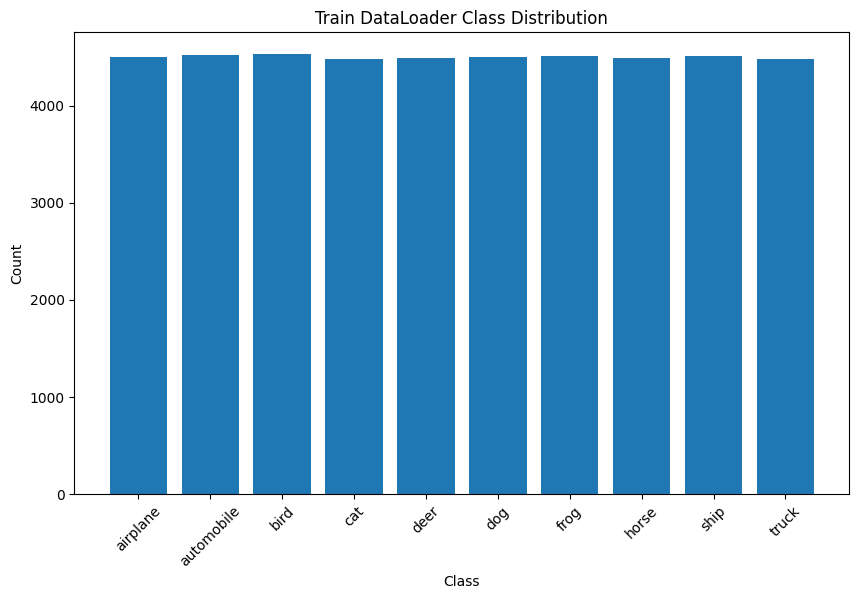

Validation DataLoader Distribution:
  airplane: 499
  automobile: 483
  bird: 473
  cat: 519
  deer: 516
  dog: 503
  frog: 489
  horse: 509
  ship: 490
  truck: 519


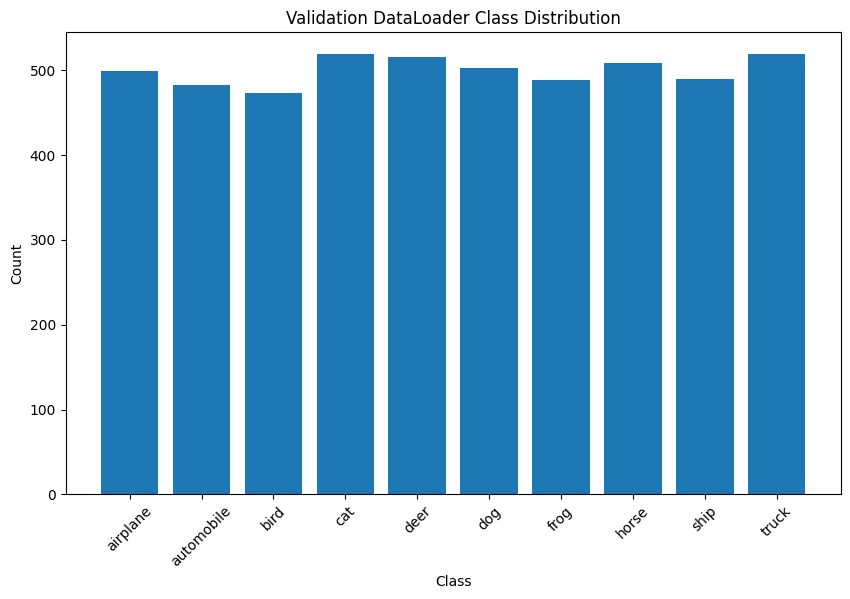

Test DataLoader Distribution:
  airplane: 1000
  automobile: 1000
  bird: 1000
  cat: 1000
  deer: 1000
  dog: 1000
  frog: 1000
  horse: 1000
  ship: 1000
  truck: 1000


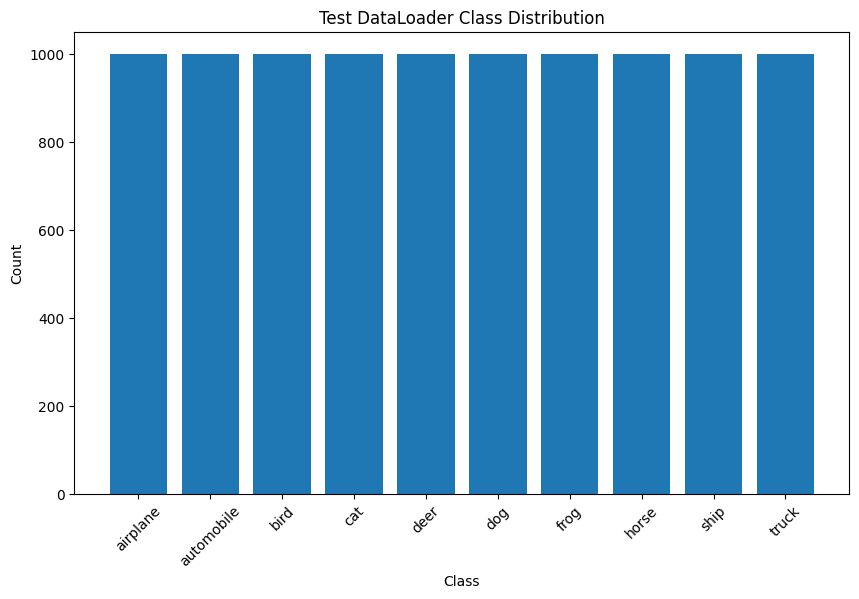

In [ ]:
# CIFAR-10 classes.
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

# Compute and display class distribution for each DataLoader.
for loader, name in [(train_loader, "Train"), (val_loader, "Validation"), (test_loader, "Test")]:
    distribution = get_class_distribution(loader, cifar10_classes)
    print(f"{name} DataLoader Distribution:")
    for cls, count in distribution.items():
        print(f"  {cls}: {count}")
    display_class_distribution(distribution, title=f"{name} DataLoader Class Distribution")

## Visualize CIFAR-10 images

Now let's visualize a few examples from each class in the CIFAR-10 dataset.

By displaying images alongside their corresponding class labels, we can verify the dataset’s contents and ensure the classes are represented correctly.

This visualization helps us understand the data distribution and provides insights into the dataset’s characteristics.

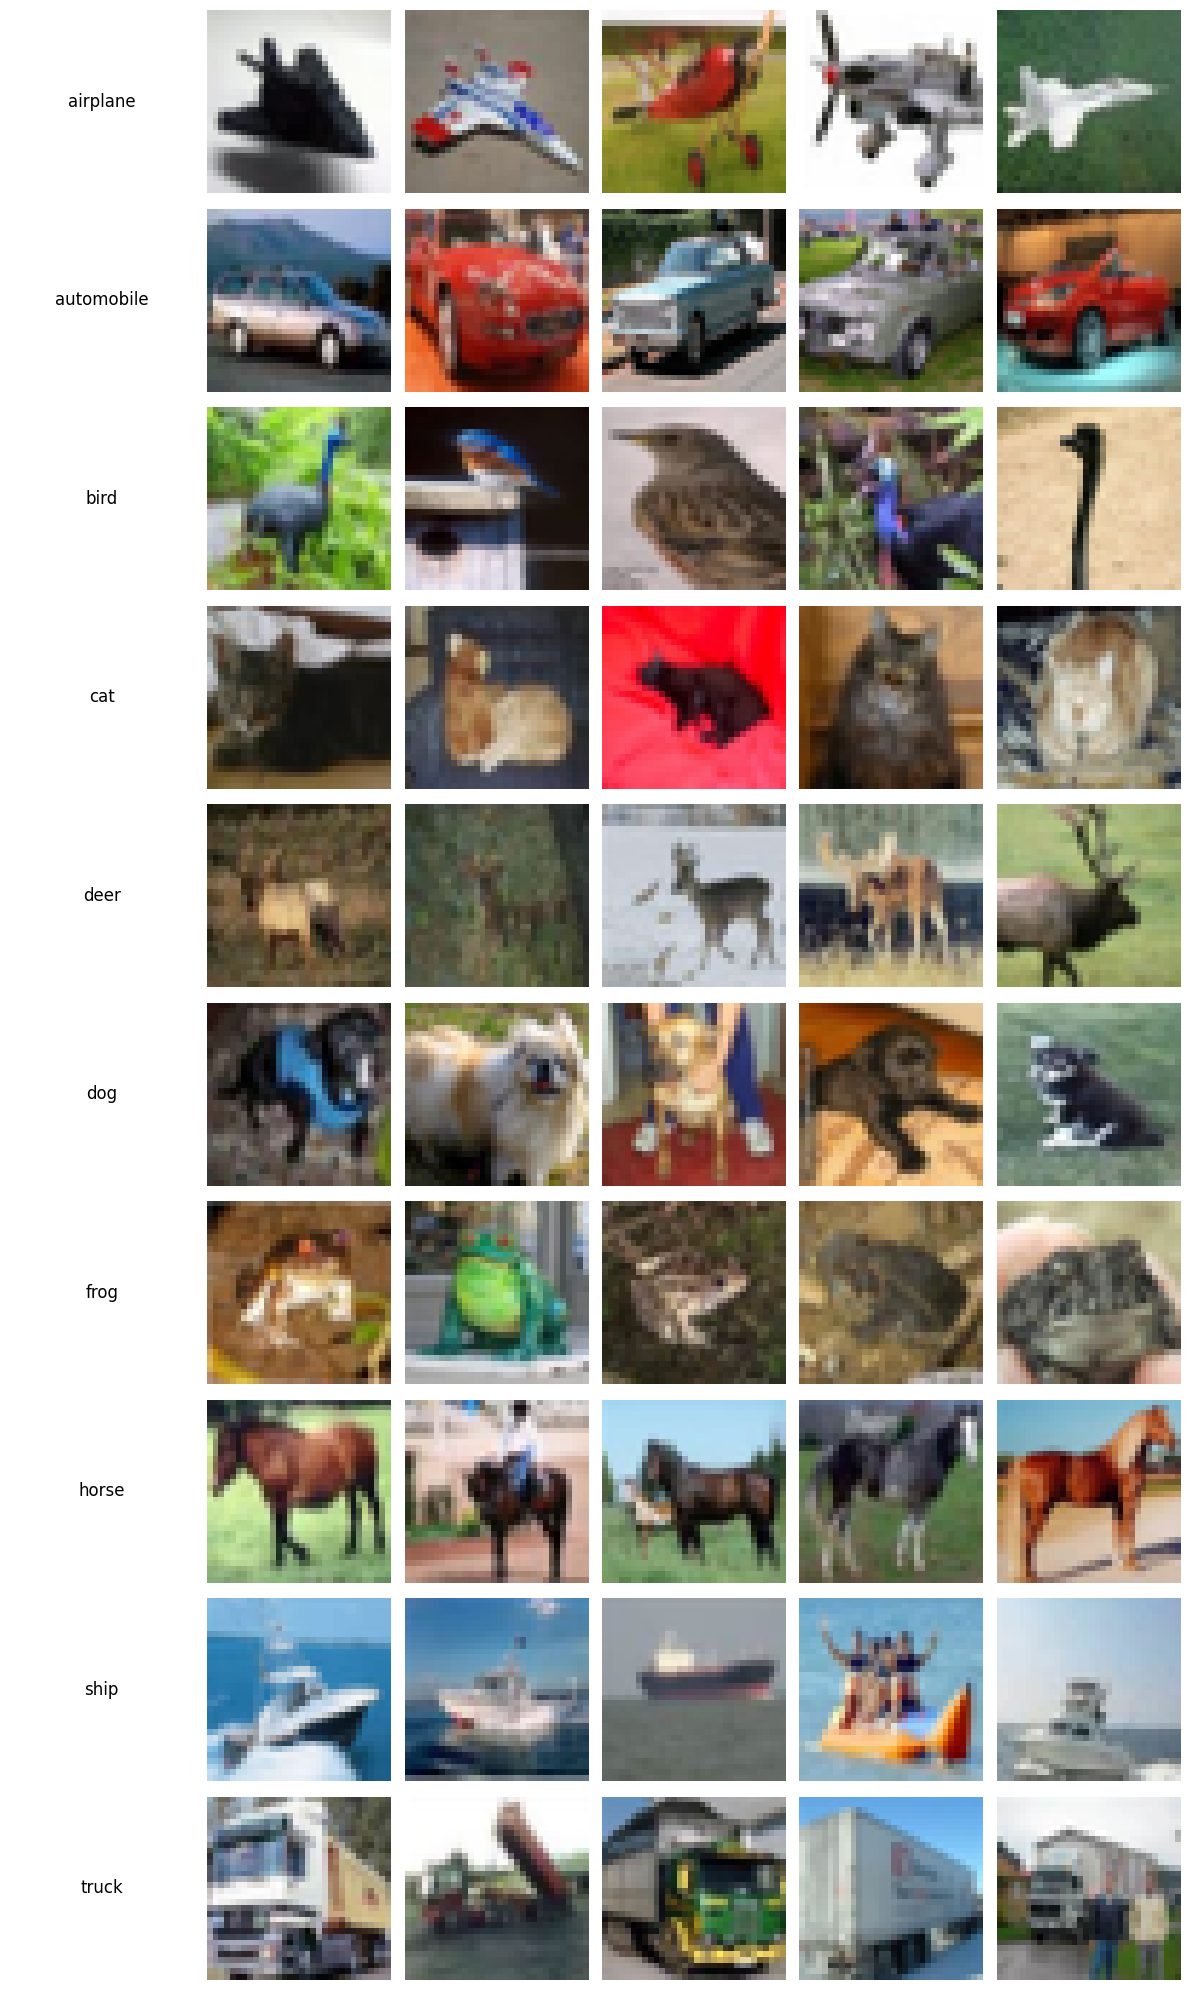

In [ ]:
import matplotlib.pyplot as plt

def visualize_images_per_class(dataset, dataset_classes, num_images=5):
    """
    Visualizes a few images from each class in the dataset.

    Args:
    - dataset: The dataset to sample from.
    - dataset_classes: List of class names for the dataset.
    - num_images: Number of images to display per class.
    """
    class_to_indices = {cls: [] for cls in range(len(dataset_classes))}

    # Group indices by class.
    for idx, (_, label) in enumerate(dataset):
        if len(class_to_indices[label]) < num_images:
            class_to_indices[label].append(idx)
        if all(len(indices) == num_images for indices in class_to_indices.values()):
            break

    # Plot the images.
    fig, axes = plt.subplots(len(dataset_classes), num_images + 1, figsize=((num_images + 1) * 2, len(dataset_classes) * 2))
    for cls_idx, cls_name in enumerate(dataset_classes):
        indices = class_to_indices[cls_idx]

        # Add class name to the first column of each row.
        axes[cls_idx, 0].text(0.5, 0.5, cls_name, fontsize=12, ha='center', va='center', transform=axes[cls_idx, 0].transAxes)
        axes[cls_idx, 0].axis("off")

        for img_idx, data_idx in enumerate(indices):
            img, label = dataset[data_idx]
            ax = axes[cls_idx, img_idx + 1]  # Shift by 1 for the class name column.
            img = img.permute(1, 2, 0)  # Convert CHW to HWC.
            img = img * torch.tensor(std).view(1, 1, 3) + torch.tensor(mean).view(1, 1, 3)  # De-normalize.
            img = torch.clamp(img, 0, 1)  # Clip values to valid range.
            ax.imshow(img)
            ax.axis("off")
    plt.tight_layout()
    plt.show()

# Visualize 5 images per class for CIFAR-10 train set.
visualize_images_per_class(cifar10_dataset, cifar10_classes, num_images=5)

# Introduction to Vision Transformers

## From Transformers to Vision Transformers

Transformers, originally introduced in natural language processing (NLP) through the groundbreaking [“Attention is All You Need”](https://arxiv.org/abs/1706.03762) paper, revolutionized the way sequential data is processed.

They replaced recurrent neural networks (RNNs) and convolutional neural networks (CNNs) in NLP with a mechanism based on *multi-head self-attention* (MHSA), enabling models to capture long-range dependencies and parallelize computation effectively.

This architecture laid the foundation for powerful language models like [BERT](https://arxiv.org/abs/1810.04805) and [GPT](https://arxiv.org/abs/2005.14165).

The success of transformers in NLP inspired researchers to explore their potential in computer vision tasks.

This gave rise to [Vision Transformers (ViTs)](https://arxiv.org/abs/2010.11929), a novel adaptation of the transformer architecture for image processing. Unlike traditional convolutional neural networks that operate *hierarchically* with *local receptive fields*, ViTs treat images as sequences of patches, akin to words in a sentence.

Each image is divided into fixed-size patches, flattened, and linearly embedded before being fed into the transformer model.

<img src="https://tintn.github.io/assets/posts/Implementing-Vision-Transformer-from-Scratch/ViT-arch.png" alt="ViT Architecture" width="750"/>

The key innovation of ViTs is their ability to model *global relationships* between image patches using *self-attention*, allowing them to capture *long-range dependencies* in visual data.

This differs from CNNs, which rely on *localized filters* and *hierarchical feature extraction*.

Vision Transformers, when pre-trained on large-scale datasets, have demonstrated competitive performance on a variety of vision tasks, including image classification, object detection, and segmentation.

While ViTs offer flexibility and scalability, they also pose challenges!

Their performance heavily depends on the *availability of large datasets for training*, as they lack the inductive biases inherent in CNNs (e.g., translation invariance).

This has spurred the development of hybrid models that combine CNNs’ inductive biases with the global modeling power of transformers.

## ConvNets vs. Vision Transformers

As stated, **Convolutional Neural Networks** (ConvNets or CNNs) have long been the dominant architecture for image classification tasks.

However, recent advancements in deep learning have introduced **Vision Transformers** (ViTs), which adapt the success of transformers in NLP to vision tasks.

Key Differences Between CNNs and Vision Transformers:

1.	**Feature Extraction**:

-	CNNs use convolutional filters to extract spatial features from images.

-	ViTs split an image into patches, flatten them, and process them as a sequence of tokens (like words in NLP).

2.	**Global Attention**:

-	CNNs capture local patterns through small filters.

-	ViTs use self-attention mechanisms, enabling them to model long-range dependencies across the entire image.

Vision Transformer Architecture:

1.	**Patch Embedding**: The image is divided into fixed-size patches, which are flattened and projected into a higher-dimensional space.

2.	**Transformer Encoder**:
-	*Multi-Head Self-Attention*: Captures dependencies between image patches.
-	*Feedforward Neural Network*: Processes attention outputs.
-	*Residual Connections* and *Layer Normalization* stabilize training.

3.	**Classification Head**: A special `[CLS]` token is passed through the transformer layers and then projected to class logits.

<img src="https://raw.githubusercontent.com/billpsomas/simpool/master/.github/cnn_vit.png" alt="CNNs vs. ViTs" width="1000"/>

# Custom Vision Transformer with Pytorch Module API

To start with, we will implement a custom **Vision Transformer** using the `Module API`. The model architecture will include:

1.	**Patch Embedding**:

    - The input image will be split into smaller non-overlapping patches.

    - Each patch will be projected into a fixed-size embedding vector using a learnable linear projection.

2. **Position Embeddings**:

    - Learnable position embeddings will be added to each patch embedding to encode spatial information.

3. **`[CLS]` token**:

    - A learnable `[CLS]` token will be prepended to the sequence of patch embeddings, which will serve as a representation of the entire image for classification.

2.	**Transformer Encoder**:

- A stack of transformer blocks, each consisting of:

    -	Multi-head self-attention (MHSA).

    -	Feedforward neural network (FFN) / Multi-layer Perceptron (MLP).

    -	Skip connections and layer normalization.

3.	**Classification Head**: A linear classifier that takes the `[CLS]` token’s representation from the transformer encoder and projects it into class logits.

### Configuration Parameters

Throught the implementation below, we are going to need some configuration parameters. These are:

1. **Patch Size (`patch_size`)**: Determines the size of each patch. For an input image of size 32x32, a patch size of 4 results in a sequence of 8x8 = 64 patches.
2. **Hidden Size (`hidden_size`)**: The dimensionality of the embeddings and transformer layers.
3. **Number of Transformer Layers (`num_hidden_layers`)**: Specifies the number of transformer blocks in the encoder.
4. **Number of Attention Heads (`num_attention_heads`)**: Defines how many independent attention mechanisms are computed in parallel.
5. **Intermediate Size (`intermediate_size`)**: The size of the feed-forward network within each transformer block. Typically set to 4 times the `hidden_size`.
6. **Dropout Probabilities (`hidden_dropout_prob`, `attention_probs_dropout_prob`)**: Dropout rates for regularization during training.
7. **Image Size (`image_size`)**: The height and width of the input images (assumes square images).
8. **Number of Classes (`num_classes`)**: The number of output classes (e.g., 10 for CIFAR-10).
9. **Number of Channels (`num_channels`)**: The number of channels in the input images (e.g., 3 for RGB images).
10. **Query-Key-Value Bias (`qkv_bias`)**: Whether to include biases in the query, key, and value projections.
11. **Initializer Range (`initializer_range`)**: The standard deviation for weight initialization.

```python
# Configuration for custom ViT model
config = {
    "patch_size": 4,  # Input image size: 32x32 -> 8x8 patches
    "hidden_size": 48,
    "num_hidden_layers": 4,
    "num_attention_heads": 4,
    "intermediate_size": 4 * 48,  # 4 * hidden_size
    "hidden_dropout_prob": 0.0,
    "attention_probs_dropout_prob": 0.0,
    "initializer_range": 0.02,
    "image_size": 32,
    "num_classes": 10,  # CIFAR-10 number of classes
    "num_channels": 3,
    "qkv_bias": True,
    "use_faster_attention": True,
}
```

## Module API: Patch Embedding

In this step, we will implement the `PatchEmbedding` module, which converts an image into a sequence of flattened patches and projects each patch into a fixed-size embedding vector.

### Key Steps:

1. Use a convolutional layer (`nn.Conv2d()`) to split the image into non-overlapping patches and project each patch into a vector space of size `hidden_size`.
2. Flatten the spatial dimensions of the patches and rearrange them into a sequence of embeddings.
3. Return the sequence of patch embeddings.

The input to the `PatchEmbedding` module will be a batch of images of shape `(batch_size, num_channels, image_size, image_size)`.

The output will be a tensor of shape `(batch_size, num_patches, hidden_size)`.

### Implementation

In [ ]:
class PatchEmbedding(nn.Module):
    """
    Converts an image into a sequence of flattened patches and projects them into a vector space.

    Parameters:
    - config: A dictionary containing the following keys:
        - "image_size" (int): The height and width of the input image (assumes square images).
        - "patch_size" (int): The height and width of each patch (assumes square patches).
        - "num_channels" (int): The number of input channels (e.g., 3 for RGB images).
        - "hidden_size" (int): The dimensionality of the output embedding for each patch.
    """

    def __init__(self, config):
        super().__init__()
        # Extract configuration parameters.
        self.image_size = config["image_size"]
        self.patch_size = config["patch_size"]
        self.num_channels = config["num_channels"]
        self.hidden_size = config["hidden_size"]

        # Calculate the number of patches.
        self.num_patches = (self.image_size // self.patch_size) ** 2 # image_size/patch_size per dimension.

        # Define the projection layer (using conv layer), which splits the image into non-overlapping patches and projects them (each patch into a vector space of hidden_layer dimension).
        self.projection = nn.Conv2d(
            in_channels=self.num_channels,
            out_channels=self.hidden_size,
            kernel_size=self.patch_size,
            stride=self.patch_size # Non-overlapping patches.
            )

    def forward(self, x):
        """
        Forward pass:
        - Input: A batch of images with shape (batch_size, num_channels, image_size, image_size)
        - Output: A tensor of shape (batch_size, num_patches, hidden_size), where each patch is projected into a hidden vector space.
        """

        # Apply the projection layer to split the image into patches.
        x = self.projection(x) # (batch_size, hidden_size, patch_height, patch_width).

        # Flatten the spatial dimensions and rearrange into a sequence.
        #x = x.view(x.shape[0], x.shape[1], x.shape[2] * x.shape[3]) # flattened output: (batch_size, hidden_size, num_patches)
        #x = x.permute(0, 2, 1) # (batch_size, num_patches, hidden_size)
        x = x.flatten(2).permute(0, 2, 1)  # flatten spatial dimensions and permute in one step.

        return x

In [ ]:
# Sanity check for the shapes with a simple example.
config1 = {
    "image_size": 32,
    "patch_size": 8,
    "num_channels": 3,
    "hidden_size": 128
}

patch_embedding = PatchEmbedding(config1)

x = torch.randn(4, 3, 32, 32) # a dummy image to check the shapes.

output = patch_embedding(x)
print(output.shape)  # should be (4, num_patches=16, 128).

torch.Size([4, 16, 128])


## Module API: Embeddings

The `Embeddings` module combines patch embeddings with a learnable [CLS] token and positional embeddings. These embeddings form the input sequence for the transformer encoder.

### Key Steps:

1. Generate patch embeddings for the input image using the `PatchEmbedding` module.
2. Add a learnable [CLS] token at the beginning of the sequence to represent the entire image.
3. Add learnable positional embeddings to encode spatial information for each patch and the [CLS] token.
4. Apply dropout to the final sequence for regularization.

The input to the `Embeddings` module will be a batch of images of shape `(batch_size, num_channels, image_size, image_size)`.

The output will be a tensor of shape `(batch_size, num_patches + 1, hidden_size)`, where `num_patches` depends on the image size and patch size.

### Implementation

In [ ]:
class Embeddings(nn.Module):
    """
    Combines patch embeddings with the [CLS] token and position embeddings.

    This module performs the following steps:
    1. Generates patch embeddings for the input image.
    2. Adds a learnable [CLS] token at the beginning of the sequence.
    3. Adds positional embeddings to encode the spatial information.
    4. Applies dropout for regularization.

    Parameters:
    - config (dict): A dictionary containing the following keys:
        - "image_size" (int): The height and width of the input image (assumes square images).
        - "patch_size" (int): The height and width of each patch (assumes square patches).
        - "num_channels" (int): The number of input channels (e.g., 3 for RGB images).
        - "hidden_size" (int): The dimensionality of the patch embeddings and transformer embeddings.
        - "hidden_dropout_prob" (float): Dropout probability applied after adding positional embeddings.
    """

    def __init__(self, config):
        super().__init__()
        # Save configuration.
        self.config = config
        self.patch_embeddings = PatchEmbedding(config)

        # Initialize the learnable [CLS] token.
        self.cls_token = nn.Parameter(torch.zeros(1, 1, config["hidden_size"])) # Would be of (batch_size, number_of_tokens, embedding_dimension/hidden) same shape as produced patch embedding.

        # Initialize the learnable positional embeddings.
        self.position_embeddings = nn.Parameter(torch.zeros(1, self.patch_embeddings.num_patches + 1, config["hidden_size"])) # Would be of (batch_size, number_of_tokens(+1 for the cls token), embedding_dimension/hidden) same shape as as produced patch embedding +1 for the cls token.

        # Dropout for regularization.
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x):
        """
        Forward pass:
        - Input: A batch of images of shape (batch_size, num_channels, image_size, image_size)
        - Output: A sequence of embeddings of shape (batch_size, num_patches + 1, hidden_size)
        """
        # Generate patch embeddings.
        x = self.patch_embeddings(x) # (batch_size, num_patches, embedding_size/hidden_size).

        # Expand the [CLS] token to match the batch size.
        cls_token_expanded = self.cls_token.expand(x.shape[0], -1, -1) # (batch_size, 1, embedding_size/hidden_size).

        # Concatenate the [CLS] token at the beginning of the patch embeddings
        x = torch.cat([cls_token_expanded, x], dim=1) # (batch_size, num_patches+1, embedding_size/hidden_size).

        # Add positional embeddings
        x = x + self.position_embeddings # (batch_size, num_patches+1, embedding_size/hidden_size).

        # Apply dropout.
        x = self.dropout(x)

        return x

In [ ]:
# Sanity check for the shapes with a simple example.
config2 = {
    "image_size": 224,
    "patch_size": 16,
    "num_channels": 3,
    "hidden_size": 768,
    "hidden_dropout_prob": 0.1
}

embeddings = Embeddings(config2)

x = torch.randn(8, 3, 224, 224) # Random image of (batch_size=8, num_channels=3, image_size=224).
output = embeddings(x)
print(output.shape) # Expected (8, (224//16)**2 + 1 = 197, 768).

torch.Size([8, 197, 768])


## Module API: Attention head

In this step, we will implement a single `AttentionHead` for the self-attention mechanism.

An attention head is a critical component of the transformer architecture, allowing the model to focus on different parts of the input sequence.

### Key Steps:

1. Project the input tensor into **query**, **key**, and **value** vectors using linear layers.
2. Compute the **scaled dot-product attention**:
   
   $\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{Q \cdot K^T}{\sqrt{d_k}}\right) \cdot V$
   
3. Apply dropout to the attention probabilities for regularization.
4. Return:
   - **Attention Output**: A tensor of shape `(batch_size, sequence_length, attention_head_size)`.
   - **Attention Probabilities**: A tensor of shape `(batch_size, sequence_length, sequence_length)`.

The input to the `AttentionHead` module will be a tensor of shape `(batch_size, sequence_length, hidden_size)`.

### Implementation

In [ ]:
class AttentionHead(nn.Module):
    """
    Implements a single attention head for self-attention.

    This module performs the following steps:
    1. Projects the input into query, key, and value vectors.
    2. Computes scaled dot-product attention:
        - attention(Q, K, V) = softmax(Q * K^T / sqrt(d_k)) * V
    3. Applies dropout to the attention probabilities for regularization.

    Parameters:
    - hidden_size (int): Dimensionality of the input embeddings.
    - attention_head_size (int): Dimensionality of each attention head.
    - dropout (float): Dropout probability applied to attention probabilities.
    - bias (bool): Whether to include biases in the projection layers (default: True).
    """

    def __init__(self, hidden_size, attention_head_size, dropout, bias=True):
        super().__init__()
        # Save dimensions.
        self.hidden_size = hidden_size
        self.attention_head_size = attention_head_size # d_k

        # Define linear layers to compute query, key, and value vectors.
        self.query = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.key = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.value = nn.Linear(hidden_size, attention_head_size, bias=bias)

        # Dropout for regularization.
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        Forward pass:
        - Input: A tensor of shape (batch_size, sequence_length, hidden_size)
        - Output:
          - attention_output: A tensor of shape (batch_size, sequence_length, attention_head_size)
          - attention_probs: The attention probabilities (batch_size, sequence_length, sequence_length)
        """
        # Compute query, key, and value vectors.
        query = self.query(x)  # Shape: (batch_size, sequence_length, attention_head_size).
        key = self.key(x)      # Shape: (batch_size, sequence_length, attention_head_size).
        value = self.value(x)  # Shape: (batch_size, sequence_length, attention_head_size).

        # Compute attention scores.
        attention_scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(self.attention_head_size) # (batch_size,sequence_length,attention_head_size)x(batch_size,attention_head_size,sequence_length) =(batch_size, sequence_length, sequence_length).

        # Apply softmax to get attention probabilities.
        attention_probs = torch.softmax(attention_scores, dim=-1)

        # Apply dropout to attention probabilities.
        attention_probs = self.dropout(attention_probs)

        # Compute attention output.
        attention_output = torch.matmul(attention_probs, value) # (batch_size, sequence_length, attention_head_size).

        return attention_output, attention_probs

In [ ]:
# Sanity check.
config3 = {
    "image_size": 32,
    "patch_size": 4,
    "num_channels": 3,
    "hidden_size": 48,
    "hidden_dropout_prob": 0.1
}

# Instantiate Embeddings.
embeddings = Embeddings(config3)

# Create a dummy batch of 2 images (batch_size=2, num_channels=3, image_size=32x32).
dummy_images = torch.randn(2, config3["num_channels"], config3["image_size"], config3["image_size"])

# Forward pass of the dummy images from the begining.
embedding_output = embeddings(dummy_images)  # output shape: (batch_size, num_patches + 1, hidden_size).
print("Embeddings output shape:", embedding_output.shape)

# Instantiate AttentionHead.
attention_head = AttentionHead(
    hidden_size=config3["hidden_size"],
    attention_head_size=config3["hidden_size"] // 3,  # example: 3 attention heads.
    dropout=0.1,
    bias=True
)

# Embedding output to the AttentionHead.
attention_output, attention_probs = attention_head(embedding_output)

# Output shapes.
print("Attention output shape:", attention_output.shape)  # (batch_size, sequence_length, attention_head_size).
print("Attention probabilities shape:", attention_probs.shape)

Embeddings output shape: torch.Size([2, 65, 48])
Attention output shape: torch.Size([2, 65, 16])
Attention probabilities shape: torch.Size([2, 65, 65])


## Module API: Multi-head self-attention (MHSA)

The `MultiHeadAttention` module implements the multi-head attention mechanism used in transformers.

Multi-head attention allows the model to focus on different parts of the input sequence simultaneously by splitting the attention computation across multiple attention heads.

### Key Steps:
1. Compute attention for each head independently using the `AttentionHead` module.
2. Concatenate the outputs from all heads along the last dimension.
3. Project the concatenated outputs back to the hidden size using a linear layer.
4. Optionally return attention probabilities for visualization or analysis.

The input to the `MultiHeadAttention` module will be a tensor of shape `(batch_size, sequence_length, hidden_size)`. The output will include:
- **Attention Output**: A tensor of shape `(batch_size, sequence_length, hidden_size)`.
- **Attention Probabilities** (optional): A tensor of shape `(batch_size, num_heads, sequence_length, sequence_length)` if `output_attentions=True`.

### Implementation



In [ ]:
class MultiHeadAttention(nn.Module):
    """
    Implements the multi-head attention mechanism for transformers.

    Multi-head attention allows the model to jointly focus on different parts of the input sequence by splitting
    the attention computation across multiple attention heads. This module:
    1. Computes attention for each head independently using the `AttentionHead` module.
    2. Concatenates the outputs from all heads.
    3. Projects the concatenated output back to the hidden size dimension.

    Parameters:
    - config (dict): Configuration dictionary containing:
        - "hidden_size" (int): Dimensionality of the input and output embeddings.
        - "num_attention_heads" (int): Number of attention heads.
        - "qkv_bias" (bool): Whether to include biases in query, key, and value projections.
        - "attention_probs_dropout_prob" (float): Dropout probability for attention probabilities.
        - "hidden_dropout_prob" (float): Dropout probability for the output projection layer.
    """

    def __init__(self, config):
        super().__init__()

        # Extract configuration parameters.
        self.hidden_size = config["hidden_size"]
        self.num_attention_heads = config["num_attention_heads"]
        self.qkv_bias = config["qkv_bias"]

        # Compute the size of each attention head.
        self.attention_head_size = self.hidden_size // self.num_attention_heads

        assert (
            self.hidden_size % self.num_attention_heads == 0
        ), "hidden_size must be divisible by num_attention_heads."

        # Total size of all heads combined.
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        # Define attention heads as a list of independent `AttentionHead` modules.
        self.attention_heads = nn.ModuleList([
            AttentionHead(
                hidden_size=self.hidden_size,
                attention_head_size=self.attention_head_size,
                dropout=config["attention_probs_dropout_prob"],
                bias=self.qkv_bias,
            )
            for _ in range(self.num_attention_heads)
        ])

        # Define the output projection layer.
        self.output_projection = nn.Linear(self.all_head_size, self.hidden_size, bias=config["qkv_bias"])

        # Define dropout for the output projection.
        self.output_dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x, output_attentions=False):
        """
        Forward pass for multi-head attention.

        Parameters:
        - x (Tensor): Input tensor of shape (batch_size, sequence_length, hidden_size).
        - output_attentions (bool): If True, returns attention probabilities for each head.

        Returns:
        - attention_output (Tensor): Output tensor of shape (batch_size, sequence_length, hidden_size).
        - attention_probs (Tensor, optional): Attention probabilities for each head of shape
          (batch_size, num_heads, sequence_length, sequence_length) if `output_attentions` is True.
        """

        # Compute attention for each head.
        attention_outputs = [attention_head(x) for attention_head in self.attention_heads] # Create num_attention_heads.

        # Concatenate the attention outputs from all heads.
        conc_attention_output = torch.cat([output for output, _ in attention_outputs], dim=-1) # Attention_probs at _.

        # Project the concatenated outputs back to hidden_size.
        attention_output = self.output_projection(conc_attention_output)
        attention_output = self.output_dropout(attention_output) # Apply dropout defined above for the output of projection.

        # Optionally return attention probabilities.
        if output_attentions:
            attention_probs = torch.stack(
                [attention_probs for _, attention_probs in attention_outputs], dim=1
            )  # Shape: (batch_size, num_heads, sequence_length, sequence_length).
            return attention_output, attention_probs

        return attention_output, None

In [ ]:
# Test on a dummy example.
config = {
    "patch_size": 4,
    "hidden_size": 48,
    "num_attention_heads": 4,
    "attention_probs_dropout_prob": 0.0,
    "hidden_dropout_prob": 0.0,
    "image_size": 32,
    "num_channels": 3,
    "qkv_bias": True
}
# Create a random image.
dummy_images = torch.randn(2, config["num_channels"], config["image_size"], config["image_size"])
print("Input shape:", dummy_images.shape)

# Embeddings.
embeddings = Embeddings(config)
embedding_out = embeddings(dummy_images)
print("Embedding output shape:", embedding_out.shape)

# Attentions.
multi_head_attention = MultiHeadAttention(config)
attention_output, attention_probs = multi_head_attention(embedding_out, output_attentions=True)
print("Multi-head attention output shape:", attention_output.shape)
print("Multi-head attention probabilities shape:", attention_probs.shape)

Input shape: torch.Size([2, 3, 32, 32])
Embedding output shape: torch.Size([2, 65, 48])
Multi-head attention output shape: torch.Size([2, 65, 48])
Multi-head attention probabilities shape: torch.Size([2, 4, 65, 65])


## Module API: Multi-layer Perceptron (MLP)

The `MLP` module implements a feedforward neural network used in transformers. This component processes the output of the attention mechanism, applies a non-linear transformation, and projects it back to the original dimension.


### Key Steps:

1. Expand the input dimension using a fully connected layer.
2. Apply a non-linear activation function, such as GELU.
3. Reduce the dimension back to the input size using a second fully connected layer.
4. Apply dropout for regularization.

The input to the `MLP` module will be a tensor of shape `(batch_size, sequence_length, hidden_size)`. The output will have the same shape.


### Implementation

In [ ]:
class MLP(nn.Module):
    """
    Implements a multi-layer perceptron (MLP) module for transformers.

    This module applies the following steps:
    1. A fully connected (dense) layer that expands the input dimension.
    2. A non-linear activation function (e.g., GELU).
    3. A second fully connected layer that projects the expanded dimension back to the input size.
    4. Dropout for regularization.

    Parameters:
    - config (dict): Configuration dictionary containing:
        - "hidden_size" (int): Dimensionality of the input and output embeddings.
        - "intermediate_size" (int): Dimensionality of the expanded hidden layer.
        - "hidden_dropout_prob" (float): Dropout probability applied after the second dense layer.
    """

    def __init__(self, config):
        super().__init__()

        # Define the first fully connected layer to expand the input dimension.
        self.dense_1 = nn.Linear(config["hidden_size"], config["intermediate_size"])

        # Define the non-linear activation function.
        self.gelu = nn.GELU()

        # Define the second fully connected layer to project back to the input dimension.
        self.dense_2 = nn.Linear(config["intermediate_size"], config["hidden_size"])

        # Dropout for regularization.
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x):
        """
        Forward pass:
        - Input: A tensor of shape (batch_size, sequence_length, hidden_size).
        - Output: A tensor of shape (batch_size, sequence_length, hidden_size).
        """

        # Apply the first dense layer.
        x = self.dense_1(x)

        # Apply the activation function.
        x = self.gelu(x)

        # Apply the second dense layer.
        x = self.dense_2(x)

        # Apply dropout.
        x = self.dropout(x)

        return x

## Module API: Transformer Block

The `Block` module implements a single **transformer block**, which combines multi-head self-attention (MHSA) and a feed-forward network (MLP), each followed by layer normalization and residual connections.


### Key Steps:
1. Apply **Layer Normalization** before the self-attention mechanism.
2. Compute **Multi-Head Self-Attention** and add a **residual connection** (skip connection).
3. Apply **Layer Normalization** before the feed-forward network (MLP).
4. Compute the **Feed-Forward Network (MLP)** and add another **residual connection**.
5. Optionally return the **attention probabilities** for analysis or visualization.

The input to the `Block` module will be a tensor of shape `(batch_size, sequence_length, hidden_size)`. The output will have the same shape, with an optional tensor of attention probabilities.


### Implementation

In [ ]:
class Block(nn.Module):
    """
    Implements a single transformer block.

    A transformer block consists of:
    1. A multi-head self-attention mechanism with skip connection and layer normalization.
    2. A feed-forward network (FFN) with skip connection and layer normalization.

    Parameters:
    - config (dict): Configuration dictionary containing:
        - "hidden_size" (int): Dimensionality of the input and output embeddings.
        - "num_attention_heads" (int): Number of attention heads for the multi-head attention mechanism.
        - "qkv_bias" (bool): Whether to include biases in query, key, and value projections for attention.
        - "attention_probs_dropout_prob" (float): Dropout probability for attention probabilities.
        - "intermediate_size" (int): Dimensionality of the expanded hidden layer in the MLP.
        - "hidden_dropout_prob" (float): Dropout probability applied in the MLP and output projection.
    """

    def __init__(self, config):
        super().__init__()

        # Initialize the multi-head self-attention mechanism (MHSA).
        self.attention = MultiHeadAttention(config)

        # Initialize layer normalization before self-attention.
        self.layernorm_1 = nn.LayerNorm(config["hidden_size"])

        # Initialize the feed-forward network (MLP).
        self.mlp = MLP(config)

        # Initialize layer normalization before the MLP.
        self.layernorm_2 = nn.LayerNorm(config["hidden_size"])

    def forward(self, x, output_attentions=False):
        """
        Forward pass for a transformer block.

        Parameters:
        - x (Tensor): Input tensor of shape (batch_size, sequence_length, hidden_size).
        - output_attentions (bool): If True, returns attention probabilities.

        Returns:
        - x (Tensor): Output tensor of shape (batch_size, sequence_length, hidden_size).
        - attention_probs (Tensor, optional): Attention probabilities of shape
          (batch_size, num_heads, sequence_length, sequence_length) if `output_attentions` is True.
        """
        # Apply layer normalization before self-attention.
        normalized_x = self.layernorm_1(x)

        # Compute self-attention
        attention_output, attention_probs = self.attention(normalized_x, output_attentions=True)

        # Add skip connection (residual connection) after self-attention.
        x = x + attention_output

        # Apply layer normalization before the MLP.
        normalized_x = self.layernorm_2(x)

        # Compute feed-forward network (MLP)
        mlp_output = self.mlp(normalized_x)

        # Add skip connection (residual connection) after the MLP.
        x = x + mlp_output # x: output of first sub-block, before the second norm layer.

        # Return output and optionally the attention probabilities.
        if output_attentions:
            return x, attention_probs
        return x, None

## Module API: Transformer Encoder

The `Encoder` module implements the **transformer encoder**, which is composed of multiple stacked transformer blocks. Each block applies multi-head self-attention (MHSA) and a multi-layer perceptron (MLP) with layer normalization and skip connections.


### Key Steps:


1. Define multiple transformer blocks using the `Block` module.
2. Pass the input through each transformer block sequentially.
3. Optionally store and return the attention probabilities for each block.

The input to the `Encoder` module will be a tensor of shape `(batch_size, sequence_length, hidden_size)`. The output will include:
- **Final Encoder Output**: A tensor of shape `(batch_size, sequence_length, hidden_size)`.
- **Attention Probabilities** (optional): A list of tensors, each containing the attention probabilities for a block.

### Implementation

In [ ]:
class Encoder(nn.Module):
    """
    Implements the transformer encoder module.

    The encoder consists of multiple transformer blocks stacked sequentially.
    Each block applies multi-head self-attention and a feed-forward network (MLP)
    with skip connections and layer normalization.

    Parameters:
    - config (dict): Configuration dictionary containing:
        - "hidden_size" (int): Dimensionality of the input and output embeddings.
        - "num_hidden_layers" (int): Number of transformer blocks in the encoder.
        - "num_attention_heads" (int): Number of attention heads for the multi-head attention mechanism.
        - "qkv_bias" (bool): Whether to include biases in query, key, and value projections.
        - "attention_probs_dropout_prob" (float): Dropout probability for attention probabilities.
        - "intermediate_size" (int): Dimensionality of the expanded hidden layer in the MLP.
        - "hidden_dropout_prob" (float): Dropout probability applied in the MLP and output projection.
    """

    def __init__(self, config):
        super().__init__()

        # Create a stack of transformer blocks (use of `nn.ModuleList()`).
        self.blocks = nn.ModuleList([Block(config) for _ in range(config["num_hidden_layers"])])


    def forward(self, x, output_attentions=False):
        """
        Forward pass for the transformer encoder.

        Parameters:
        - x (Tensor): Input tensor of shape (batch_size, sequence_length, hidden_size).
        - output_attentions (bool): If True, returns attention probabilities for each block.

        Returns:
        - x (Tensor): Output tensor of shape (batch_size, sequence_length, hidden_size).
        - all_attentions (list of Tensors, optional): List of attention probabilities, one for each block.
          Each tensor has shape (batch_size, num_heads, sequence_length, sequence_length).
        """
        # Initialize a list to store attention probabilities (if required).
        all_attentions = []

        # Pass the input through each transformer block sequentially and store the attention probabilities of each block in `all_attentions` list.
        for block in self.blocks:
          if output_attentions:
            x, attention_probs = block(x, output_attentions=output_attentions)
            all_attentions.append(attention_probs)
          else:
            x = block(x)

        # Return the encoder's final output and optionally the attention probabilities.
        if output_attentions:
            return x, all_attentions
        return x, None

## Module API: Vision Transformer

The `VisionTransformer` module implements the complete Vision Transformer (ViT) model, designed for image classification tasks. It combines patch embeddings, a transformer encoder, and a classification head.


### Key Components:

1. **Embedding Module**: Splits the input image into patches, adds positional encodings, and appends a [CLS] token.
2. **Transformer Encoder**: Processes the embeddings using stacked transformer blocks.
3. **Classification Head**: Projects the [CLS] token's output to logits for classification.

The input to the `VisionTransformer` module will be a tensor of shape `(batch_size, num_channels, image_size, image_size)`. The output will include:
- **Logits**: A tensor of shape `(batch_size, num_classes)` representing class scores.
- **Attention Probabilities** (optional): A list of tensors, one for each transformer block, for analysis or visualization.

### Implementation

In [ ]:
class VisionTransformer(nn.Module):
    """
    Vision Transformer (ViT) model for classification tasks.

    This model consists of:
    1. An embedding module that splits the input image into patches, adds positional encodings, and appends a [CLS] token.
    2. A transformer encoder composed of multiple transformer blocks.
    3. A classification head that uses the [CLS] token's output to compute logits for classification.

    Parameters:
    - config (dict): Configuration dictionary containing:
        - "image_size" (int): Height and width of the input images (assumes square images).
        - "hidden_size" (int): Dimensionality of the transformer embeddings.
        - "num_classes" (int): Number of output classes for classification.
        - "patch_size" (int): Size of each image patch (height and width, assumes square patches).
        - "num_attention_heads" (int): Number of attention heads in the multi-head attention mechanism.
        - "num_hidden_layers" (int): Number of transformer blocks in the encoder.
        - "intermediate_size" (int): Dimensionality of the expanded hidden layer in the feed-forward network.
        - "hidden_dropout_prob" (float): Dropout probability for embeddings and MLP layers.
        - "attention_probs_dropout_prob" (float): Dropout probability for attention probabilities.
        - "qkv_bias" (bool): Whether to include biases in query, key, and value projections.
    """

    def __init__(self, config):
        super().__init__()
        # Save configuration.
        self.config = config
        self.image_size = config["image_size"]
        self.hidden_size = config["hidden_size"]
        self.num_classes = config["num_classes"]

        # Initialize the embedding module.
        self.embedding = Embeddings(config)

        # Initialize the transformer encoder.
        self.encoder = Encoder(config)

        # Initialize the classification head.
        self.head = nn.Linear(config["hidden_size"], config["num_classes"]) # Plus bias(default behavior).

        # Initialize weights.
        self.apply(self._init_weights) # Recursively applies _init_weights funct to every submodule(e.g. Embedding, Block,..), ensuring all weights are properly initialized.


    def forward(self, x, output_attentions=False):
        """
        Forward pass of the ViT model.

        Parameters:
        - x (Tensor): Input tensor of shape (batch_size, num_channels, image_size, image_size).
        - output_attentions (bool): If True, returns attention probabilities for each encoder block.

        Returns:
        - logits (Tensor): Logits for classification, shape (batch_size, num_classes).
        - all_attentions (list of Tensors, optional): List of attention probabilities for each encoder block.
          Each tensor has shape (batch_size, num_heads, sequence_length, sequence_length).
        """
        # Compute embeddings.
        x = self.embedding(x)

        # Pass embeddings through the transformer encoder.
        all_attentions = [] # for attention probs
        for block in self.encoder.blocks:
          x, attention_probs = block(x, output_attentions=output_attentions)
          if output_attentions:
            all_attentions.append(attention_probs)

        # Extract the [CLS] token's output for classification.
        #print(x.shape)
        cls_token = x[:, 0, :] # Extract 1st token of the previous block output.
        logits = self.head(cls_token)

        # Return logits and optionally attention probabilities.
        if output_attentions:
            return logits, all_attentions
        return logits, None

    def _init_weights(self, module):
        """
        Initialize weights for the model using standard initialization techniques.
        """
        if isinstance(module, nn.Linear):
            nn.init.trunc_normal_(module.weight, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            nn.init.zeros_(module.bias)
            nn.init.ones_(module.weight)

## Vision Transformer Configuration

The Vision Transformer (ViT) model requires a configuration dictionary to define its architecture and behavior.

Below, we define the configuration for our custom ViT model, which is tailored for the `CIFAR-10` dataset.

This configuration will be passed to the `VisionTransformer` class to build the model.


### Key Configuration Parameters:

1. **Patch Size (`patch_size`)**: Determines the size of each patch. For an input image of size 32x32, a patch size of 4 results in a sequence of 8x8 = 64 patches.
2. **Hidden Size (`hidden_size`)**: The dimensionality of the embeddings and transformer layers.
3. **Number of Transformer Layers (`num_hidden_layers`)**: Specifies the number of transformer blocks in the encoder.
4. **Number of Attention Heads (`num_attention_heads`)**: Defines how many independent attention mechanisms are computed in parallel.
5. **Intermediate Size (`intermediate_size`)**: The size of the feed-forward network within each transformer block. Typically set to 4 times the `hidden_size`.
6. **Dropout Probabilities (`hidden_dropout_prob`, `attention_probs_dropout_prob`)**: Dropout rates for regularization during training.
7. **Image Size (`image_size`)**: The height and width of the input images (assumes square images).
8. **Number of Classes (`num_classes`)**: The number of output classes (e.g., 10 for CIFAR-10).
9. **Number of Channels (`num_channels`)**: The number of channels in the input images (e.g., 3 for RGB images).
10. **Query-Key-Value Bias (`qkv_bias`)**: Whether to include biases in the query, key, and value projections.
11. **Initializer Range (`initializer_range`)**: The standard deviation for weight initialization.

In [ ]:
# Configuration for custom ViT model.
config = {
    "patch_size": 4,  # Input image size: 32x32 -> 8x8 patches.
    "hidden_size": 48,
    "num_hidden_layers": 4,
    "num_attention_heads": 4,
    "intermediate_size": 4 * 48,  # 4 * hidden_size.
    "hidden_dropout_prob": 0.0,
    "attention_probs_dropout_prob": 0.0,
    "initializer_range": 0.02,
    "image_size": 32,
    "num_classes": 10,  # CIFAR-10 number of classes.
    "num_channels": 3,
    "qkv_bias": True,
    "use_faster_attention": True,
}

In [ ]:
# Check configuration validity.
assert config["hidden_size"] % config["num_attention_heads"] == 0
assert config["intermediate_size"] == 4 * config["hidden_size"]
assert config["image_size"] % config["patch_size"] == 0

## Vision Transformer Trainer

The `Trainer` class manages the training and evaluation process for the Vision Transformer (ViT). It encapsulates the following functionalities:

1. **Initialization**: Accepts the model, optimizer, loss function, and device (CPU/GPU), ensuring the model is moved to the correct device.

2. **Training**: The `train_epoch` method:
   - Iterates through training batches using a `tqdm` progress bar.
   - Performs forward passes, computes loss, backpropagates, and updates model parameters.
   - Returns the average training loss for the epoch.

3. **Evaluation**: The `evaluate` method:
   - Runs the model on a validation or test set in evaluation mode (`model.eval()`).
   - Computes accuracy and average loss, displaying progress with a `tqdm` bar.

4. **Full Training Loop**: The `train` method:
   - Combines `train_epoch` and `evaluate` for multiple epochs.
   - Logs training loss, validation loss, and accuracy after each epoch.

This modular approach ensures efficient, reusable, and well-organized training and evaluation for the ViT.

### Implementation:

In [ ]:
class Trainer:
    def __init__(self, model, optimizer, loss_fn, device):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.device = device

    def train_epoch(self, train_loader):
        """
        Train the model for one epoch with a progress bar.
        """
        self.model.train()
        total_loss = 0

        # Initialize tqdm progress bar.
        with tqdm(train_loader, desc="Training", unit="batch") as t:
            for images, labels in t:
                images, labels = images.to(self.device), labels.to(self.device)

                # Zero gradients.
                self.optimizer.zero_grad()

                # Forward pass.
                logits, _ = self.model(images)

                # Compute loss.
                loss = self.loss_fn(logits, labels)

                # Backward pass.
                loss.backward()

                # Update parameters.
                self.optimizer.step()

                # Accumulate loss.
                total_loss += loss.item() * len(images)

                # Update progress bar.
                t.set_postfix(loss=loss.item())

        # Average loss.
        return total_loss / len(train_loader.dataset)

    @torch.no_grad()
    def evaluate(self, dataloader):
        """
        Evaluate the model on the given dataloader with a progress bar.
        """
        self.model.eval()
        total_loss = 0
        correct = 0

        # Initialize tqdm progress bar.
        with tqdm(dataloader, desc="Validating", unit="batch") as t:
            for images, labels in t:
                images, labels = images.to(self.device), labels.to(self.device)

                # Forward pass.
                logits, _ = self.model(images)

                # Compute loss.
                loss = self.loss_fn(logits, labels)
                total_loss += loss.item() * len(images)

                # Compute accuracy.
                predictions = torch.argmax(logits, dim=1)
                correct += (predictions == labels).sum().item()

        accuracy = correct / len(dataloader.dataset)
        avg_loss = total_loss / len(dataloader.dataset)

        return accuracy, avg_loss

    def train(self, train_loader, val_loader, epochs):
        """
        Train the model for the specified number of epochs.
        """
        train_losses, val_losses, accuracies = [], [], []

        for epoch in range(epochs):
            print(f"Epoch {epoch + 1}/{epochs}")

            # Train for one epoch.
            train_loss = self.train_epoch(train_loader)

            # Evaluate on the val set.
            accuracy, val_loss = self.evaluate(val_loader)

            # Record metrics.
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            accuracies.append(accuracy)

            # Print epoch metrics.
            print(f"Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.4f}")

        # Return the training history.
        return train_losses, val_losses, accuracies

## Training of Custom Vision Transformer

Now, it's time to train our custom Vision Transformer (ViT) model on CIFAR-10. We'll define the training parameters and utilize the `Trainer` class to handle the training and validation processes efficiently. Here's what this step entails:

1. **Training Parameters**:
   - `batch_size`: Defines the number of samples per batch during training.
   - `epochs`: The number of times the model sees the entire training dataset.
   - `learning_rate`: The step size for the optimizer when updating the model parameters.

2. **Model, Optimizer, and Loss Function**:
   - The Vision Transformer is instantiated using the defined configuration (`config`).
   - The AdamW optimizer is used, which combines the advantages of both Adam and weight decay regularization.
   - Cross-Entropy Loss is applied, as it is suitable for classification tasks.

3. **Training Process**:
   - The `Trainer` class manages the training loop, tracks losses, and computes accuracy at each epoch.

### Implementation

In [ ]:
# Training parameters.
batch_size = 64
epochs = 5
learning_rate = 1e-2

# Create the model, optimizer, and loss function.
import time

model = VisionTransformer(config)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()

# Calculate and print the total trainable params.
total_params = sum(p.numel() for p in model.parameters())
print(f"Total trainable parameters: {total_params}")

# Start timer.
start_time = time.time()

# Instantiate the trainer.
trainer = Trainer(model, optimizer, loss_fn, device)

# Train the model.
train_losses, val_losses, accuracies = trainer.train(train_loader, val_loader, epochs)

# Calculate and print the total training time.
total_time = time.time() - start_time
print(f"Total training time: {total_time:.2f} seconds")

Total trainable parameters: 119098
Epoch 1/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 43.93batch/s]


Train Loss: 1.8440, Validation Loss: 1.5996, Validation Accuracy: 0.4052
Epoch 2/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 44.87batch/s]


Train Loss: 1.4802, Validation Loss: 1.4220, Validation Accuracy: 0.4864
Epoch 3/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 45.36batch/s]


Train Loss: 1.3486, Validation Loss: 1.3789, Validation Accuracy: 0.4988
Epoch 4/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 43.45batch/s]


Train Loss: 1.2749, Validation Loss: 1.2299, Validation Accuracy: 0.5460
Epoch 5/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 44.98batch/s]

Train Loss: 1.2273, Validation Loss: 1.2668, Validation Accuracy: 0.5376
Total training time: 154.50 seconds


## Experiment with Learning Rate

Hyperparameter tuning is a critical step in improving model performance. Let’s perform a learning rate search to see how it impacts the validation accuracy of our custom Vision Transformer.


Training with learning rate: 0.001
Epoch 1/5


Validating: 100%|██████████| 79/79 [00:02<00:00, 35.32batch/s]


Train Loss: 1.7926, Validation Loss: 1.6181, Validation Accuracy: 0.3888
Epoch 2/5


Validating: 100%|██████████| 79/79 [00:03<00:00, 25.78batch/s]


Train Loss: 1.4811, Validation Loss: 1.4168, Validation Accuracy: 0.4872
Epoch 3/5


Validating: 100%|██████████| 79/79 [00:04<00:00, 19.53batch/s]


Train Loss: 1.3162, Validation Loss: 1.2858, Validation Accuracy: 0.5252
Epoch 4/5


Validating: 100%|██████████| 79/79 [00:05<00:00, 15.30batch/s]


Train Loss: 1.2230, Validation Loss: 1.2191, Validation Accuracy: 0.5578
Epoch 5/5


Validating: 100%|██████████| 79/79 [00:03<00:00, 25.51batch/s]


Train Loss: 1.1542, Validation Loss: 1.2004, Validation Accuracy: 0.5590

Training with learning rate: 0.002
Epoch 1/5


Validating: 100%|██████████| 79/79 [00:03<00:00, 26.24batch/s]


Train Loss: 1.8063, Validation Loss: 1.6218, Validation Accuracy: 0.3914
Epoch 2/5


Validating: 100%|██████████| 79/79 [00:03<00:00, 22.42batch/s]


Train Loss: 1.5169, Validation Loss: 1.4363, Validation Accuracy: 0.4742
Epoch 3/5


Validating: 100%|██████████| 79/79 [00:02<00:00, 27.26batch/s]


Train Loss: 1.3240, Validation Loss: 1.3308, Validation Accuracy: 0.5232
Epoch 4/5


Validating: 100%|██████████| 79/79 [00:04<00:00, 18.39batch/s]


Train Loss: 1.2333, Validation Loss: 1.2460, Validation Accuracy: 0.5548
Epoch 5/5


Validating: 100%|██████████| 79/79 [00:02<00:00, 37.38batch/s]


Train Loss: 1.1597, Validation Loss: 1.2050, Validation Accuracy: 0.5622

Training with learning rate: 0.003
Epoch 1/5


Validating: 100%|██████████| 79/79 [00:04<00:00, 17.04batch/s]


Train Loss: 1.7873, Validation Loss: 1.5545, Validation Accuracy: 0.4276
Epoch 2/5


Validating: 100%|██████████| 79/79 [00:02<00:00, 26.91batch/s]


Train Loss: 1.4411, Validation Loss: 1.3399, Validation Accuracy: 0.5100
Epoch 3/5


Validating: 100%|██████████| 79/79 [00:02<00:00, 30.71batch/s]


Train Loss: 1.2928, Validation Loss: 1.3021, Validation Accuracy: 0.5270
Epoch 4/5


Validating: 100%|██████████| 79/79 [00:03<00:00, 21.39batch/s]


Train Loss: 1.1956, Validation Loss: 1.2153, Validation Accuracy: 0.5574
Epoch 5/5


Validating: 100%|██████████| 79/79 [00:04<00:00, 16.11batch/s]


Train Loss: 1.1221, Validation Loss: 1.1749, Validation Accuracy: 0.5760

Training with learning rate: 0.005
Epoch 1/5


Validating: 100%|██████████| 79/79 [00:04<00:00, 19.74batch/s]


Train Loss: 1.7927, Validation Loss: 1.6658, Validation Accuracy: 0.3814
Epoch 2/5


Validating: 100%|██████████| 79/79 [00:03<00:00, 21.84batch/s]


Train Loss: 1.4480, Validation Loss: 1.3461, Validation Accuracy: 0.5036
Epoch 3/5


Validating: 100%|██████████| 79/79 [00:03<00:00, 19.80batch/s]


Train Loss: 1.2946, Validation Loss: 1.2197, Validation Accuracy: 0.5592
Epoch 4/5


Validating: 100%|██████████| 79/79 [00:04<00:00, 19.12batch/s]


Train Loss: 1.1964, Validation Loss: 1.2140, Validation Accuracy: 0.5624
Epoch 5/5


Validating: 100%|██████████| 79/79 [00:02<00:00, 37.64batch/s]


Train Loss: 1.1283, Validation Loss: 1.1463, Validation Accuracy: 0.5884

Training with learning rate: 0.01
Epoch 1/5


Validating: 100%|██████████| 79/79 [00:04<00:00, 16.77batch/s]


Train Loss: 1.8313, Validation Loss: 1.7780, Validation Accuracy: 0.3502
Epoch 2/5


Validating: 100%|██████████| 79/79 [00:03<00:00, 22.24batch/s]


Train Loss: 1.4971, Validation Loss: 1.4599, Validation Accuracy: 0.4776
Epoch 3/5


Validating: 100%|██████████| 79/79 [00:02<00:00, 27.44batch/s]


Train Loss: 1.3338, Validation Loss: 1.3444, Validation Accuracy: 0.5132
Epoch 4/5


Validating: 100%|██████████| 79/79 [00:03<00:00, 22.70batch/s]


Train Loss: 1.2658, Validation Loss: 1.3511, Validation Accuracy: 0.5084
Epoch 5/5


Validating: 100%|██████████| 79/79 [00:02<00:00, 37.13batch/s]


Train Loss: 1.2164, Validation Loss: 1.3168, Validation Accuracy: 0.5184

Training with learning rate: 0.02
Epoch 1/5


Validating: 100%|██████████| 79/79 [00:02<00:00, 27.36batch/s]


Train Loss: 1.9349, Validation Loss: 1.9441, Validation Accuracy: 0.3102
Epoch 2/5


Validating: 100%|██████████| 79/79 [00:03<00:00, 21.97batch/s]


Train Loss: 1.5859, Validation Loss: 1.6833, Validation Accuracy: 0.4068
Epoch 3/5


Validating: 100%|██████████| 79/79 [00:02<00:00, 29.08batch/s]


Train Loss: 1.4734, Validation Loss: 1.5418, Validation Accuracy: 0.4478
Epoch 4/5


Validating: 100%|██████████| 79/79 [00:04<00:00, 19.50batch/s]


Train Loss: 1.4160, Validation Loss: 1.5049, Validation Accuracy: 0.4756
Epoch 5/5


Validating: 100%|██████████| 79/79 [00:02<00:00, 35.14batch/s]


Train Loss: 1.3632, Validation Loss: 1.5017, Validation Accuracy: 0.4580


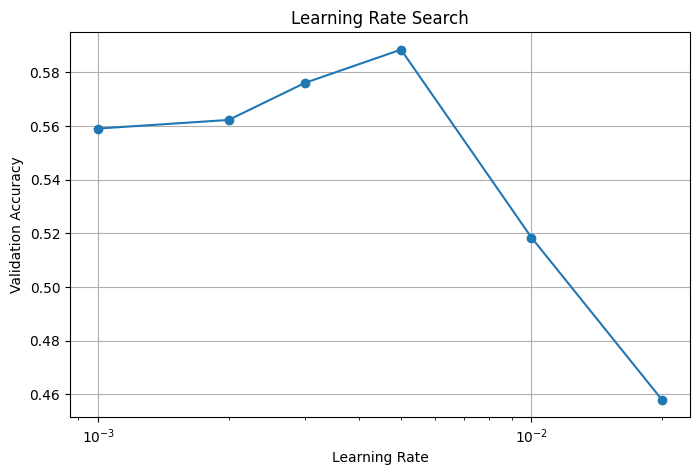

In [ ]:
import matplotlib.pyplot as plt

# Learning rates to test.
learning_rates = [1e-3, 2e-3, 3e-3, 5e-3, 1e-2, 2e-2]
epochs = 5

# Store validation accuracies.
val_accuracies = []

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")

    # Create a new model, optimizer, and loss function for each learning rate.
    model = VisionTransformer(config)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    loss_fn = torch.nn.CrossEntropyLoss()

    # Re-initialize the trainer for each learning rate(reset the training state for each lr, otherwise training for  the next lr continues from the previous lr's training state=>smoother line and not fluctuations).
    trainer = Trainer(model, optimizer, loss_fn, device)

    # Train the model and get the validation accuracy.
    _, _, accuracies = trainer.train(train_loader, val_loader, epochs)
    val_accuracies.append(accuracies[-1])  # Save the final validation accuracy.

# Plot the learning rates vs validation accuracies.
plt.figure(figsize=(8, 5))
plt.plot(learning_rates, val_accuracies, marker='o')
plt.xscale('log')  # Use a log scale for learning rates.
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')
plt.title('Learning Rate Search')
plt.grid()
plt.show()

## Experiment with Patch Size

The patch size determines how the input image is divided into smaller patches, which are then embedded into a vector space. Smaller patch sizes provide more detailed representations of the image but increase the sequence length, making the model computationally heavier. Conversely, larger patch sizes reduce the sequence length but might lose fine-grained details.

In this experiment, we will vary the patch size (`2`, `4`, and `8`) while keeping the other model configurations constant (best learning rate, as found above).


Training with patch size: 2
Total trainable parameters: 126586
Epoch 1/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 40.90batch/s]


Train Loss: 1.7327, Validation Loss: 1.5536, Validation Accuracy: 0.4142
Epoch 2/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 41.55batch/s]


Train Loss: 1.3815, Validation Loss: 1.3260, Validation Accuracy: 0.5096
Epoch 3/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 40.89batch/s]


Train Loss: 1.2614, Validation Loss: 1.1781, Validation Accuracy: 0.5736
Epoch 4/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 40.46batch/s]


Train Loss: 1.1844, Validation Loss: 1.2307, Validation Accuracy: 0.5448
Epoch 5/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 40.82batch/s]


Train Loss: 1.1226, Validation Loss: 1.1234, Validation Accuracy: 0.5934
Total training time: 190.76 seconds

Training with patch size: 4
Total trainable parameters: 119098
Epoch 1/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 43.08batch/s]


Train Loss: 1.7748, Validation Loss: 1.6025, Validation Accuracy: 0.4210
Epoch 2/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 43.40batch/s]


Train Loss: 1.4565, Validation Loss: 1.3773, Validation Accuracy: 0.4998
Epoch 3/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 43.40batch/s]


Train Loss: 1.3069, Validation Loss: 1.2578, Validation Accuracy: 0.5362
Epoch 4/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 42.61batch/s]


Train Loss: 1.2206, Validation Loss: 1.2174, Validation Accuracy: 0.5578
Epoch 5/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 42.69batch/s]


Train Loss: 1.1601, Validation Loss: 1.1812, Validation Accuracy: 0.5702
Total training time: 188.51 seconds

Training with patch size: 8
Total trainable parameters: 123706
Epoch 1/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 43.04batch/s]


Train Loss: 1.8428, Validation Loss: 1.6672, Validation Accuracy: 0.3778
Epoch 2/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 42.80batch/s]


Train Loss: 1.5856, Validation Loss: 1.5304, Validation Accuracy: 0.4350
Epoch 3/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 42.70batch/s]


Train Loss: 1.4520, Validation Loss: 1.3834, Validation Accuracy: 0.5002
Epoch 4/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 42.59batch/s]


Train Loss: 1.3512, Validation Loss: 1.3512, Validation Accuracy: 0.5174
Epoch 5/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 42.69batch/s]


Train Loss: 1.2875, Validation Loss: 1.3482, Validation Accuracy: 0.5144
Total training time: 187.83 seconds


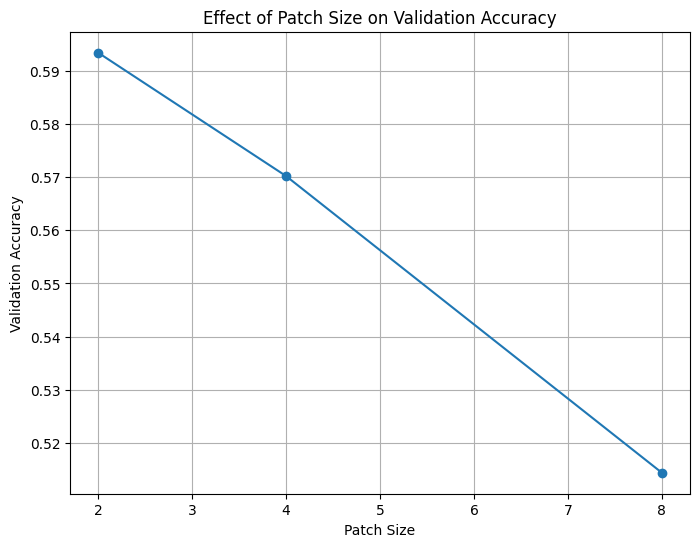

In [ ]:
# Patch sizes to experiment with.
patch_sizes = [2, 4, 8]
best_learning_rate = 5e-3

# Dictionary to store validation accuracies for each patch size.
validation_accuracies = {}

for patch_size in patch_sizes:
    print(f"\nTraining with patch size: {patch_size}")

    # Update the configuration with the current patch size.
    config["patch_size"] = patch_size
    config["hidden_size"] = 48  # Ensure hidden_size remains consistent.
    config["intermediate_size"] = 4 * config["hidden_size"]  # Update intermediate size.

    # Create a new model with the updated configuration, optimizer, loss function, and a trainer instance. Use the best learning rate.
    model = VisionTransformer(config)
    optimizer = torch.optim.AdamW(model.parameters(), lr=best_learning_rate)
    loss_fn = torch.nn.CrossEntropyLoss()

    # Print trainable params.
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total trainable parameters: {total_params}")

    # Start timer and initialize Trainer.
    start_time = time.time()

    trainer = Trainer(model, optimizer, loss_fn, device)

    # Train the model for 5 epochs and store the final validation accuracy.
    _, _, accuracies = trainer.train(train_loader, val_loader, epochs=5)
    validation_accuracies[patch_size] = accuracies[-1]

    # Calculate and print total training time.
    total_time = time.time() - start_time
    print(f"Total training time: {total_time:.2f} seconds")

# Plot the results.
import matplotlib.pyplot as plt

# Plot the patch sizes (x-axis) vs. validation accuracies (y-axis).
plt.figure(figsize=(8, 6))
plt.plot(list(validation_accuracies.keys()), list(validation_accuracies.values()), marker='o')
plt.xlabel("Patch Size")
plt.ylabel("Validation Accuracy")
plt.title("Effect of Patch Size on Validation Accuracy")
plt.grid()
plt.show()

In the experiment above, smaller patch sizes resulted in higher validation accuracy. Reflect on why this outcome was expected. Consider the following:

1.	How does the size of a patch influence the level of detail captured in the input image?

  Influence of Patch Size on Detail: Smaller patch sizes capture more fine-grained details from the input image since each patch represents a smaller portion of the image. This provides the Vision Transformer with more information about local patterns and structures, which can lead to better learning and improved accuracy.

2.	What is the trade-off between sequence length (resulting from smaller patch sizes) and model computational efficiency?

  Trade-off Between Sequence Length and Efficiency:
  Decreasing the patch size increases the number of patches (sequence length), as the input image is divided into more pieces. While this helps the model capture finer details, it also increases the computational cost of self-attention, as the complexity of attention mechanisms grows quadratically with sequence length. Therefore, there is a trade-off between capturing more detail and maintaining computational efficiency.

3.	Is it always preferable to choose the smallest possible patch size for a Vision Transformer? Why or why not?

  Choosing the Smallest Patch Size:
  While smaller patch sizes improve accuracy by capturing finer details, they are not always ideal. Extremely small patches may lead to excessively long sequences, making the model computationally expensive and harder to optimize. Moreover, some details may not be critical for the task, so the optimal patch size balances fine-grained information with computational feasibility.

In conclusion, while smaller patch sizes generally yield better accuracy, the choice of patch size should also consider the computational resources available and the nature of the dataset.

*(training with 2 patches in cpu takes 6620seconds, while in gpu only takes 257.5 !!)



## Experiment with Hidden Size

The hidden size defines the dimensionality of the patch embeddings and influences the capacity of the model. Larger hidden sizes can model more complex relationships but may overfit or require more data.

Using the best learning rate and the best patch size from the previous experiments, we now experiment with different hidden sizes in the Vision Transformer.

Training with hidden_size = 16
Total trainable parameters: 15130
Epoch 1/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 51.64batch/s]


Train Loss: 1.9107, Validation Loss: 1.7379, Validation Accuracy: 0.3442
Epoch 2/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 52.89batch/s]


Train Loss: 1.6615, Validation Loss: 1.6257, Validation Accuracy: 0.4016
Epoch 3/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 51.59batch/s]


Train Loss: 1.5430, Validation Loss: 1.5269, Validation Accuracy: 0.4288
Epoch 4/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 52.84batch/s]


Train Loss: 1.4523, Validation Loss: 1.3896, Validation Accuracy: 0.4870
Epoch 5/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 51.97batch/s]


Train Loss: 1.3959, Validation Loss: 1.3627, Validation Accuracy: 0.5024
Total training time: 110.35 seconds
Training with hidden_size = 32
Total trainable parameters: 54826
Epoch 1/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 50.48batch/s]


Train Loss: 1.8316, Validation Loss: 1.6635, Validation Accuracy: 0.3656
Epoch 2/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 50.42batch/s]


Train Loss: 1.5188, Validation Loss: 1.5426, Validation Accuracy: 0.4428
Epoch 3/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 51.22batch/s]


Train Loss: 1.3680, Validation Loss: 1.3039, Validation Accuracy: 0.5218
Epoch 4/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 50.53batch/s]


Train Loss: 1.2789, Validation Loss: 1.2513, Validation Accuracy: 0.5394
Epoch 5/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 50.92batch/s]


Train Loss: 1.2150, Validation Loss: 1.1976, Validation Accuracy: 0.5516
Total training time: 125.97 seconds
Training with hidden_size = 48
Total trainable parameters: 119098
Epoch 1/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 48.40batch/s]


Train Loss: 1.7905, Validation Loss: 1.7140, Validation Accuracy: 0.3836
Epoch 2/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 47.87batch/s]


Train Loss: 1.4633, Validation Loss: 1.4000, Validation Accuracy: 0.4878
Epoch 3/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 47.45batch/s]


Train Loss: 1.3267, Validation Loss: 1.2858, Validation Accuracy: 0.5276
Epoch 4/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 47.64batch/s]


Train Loss: 1.2375, Validation Loss: 1.3265, Validation Accuracy: 0.5282
Epoch 5/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 48.16batch/s]


Train Loss: 1.1666, Validation Loss: 1.1728, Validation Accuracy: 0.5760
Total training time: 142.24 seconds
Training with hidden_size = 64
Total trainable parameters: 207946
Epoch 1/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 46.08batch/s]


Train Loss: 1.8137, Validation Loss: 1.5687, Validation Accuracy: 0.4210
Epoch 2/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 46.18batch/s]


Train Loss: 1.4735, Validation Loss: 1.4279, Validation Accuracy: 0.4778
Epoch 3/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 46.33batch/s]


Train Loss: 1.3202, Validation Loss: 1.3740, Validation Accuracy: 0.5048
Epoch 4/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 46.00batch/s]


Train Loss: 1.2331, Validation Loss: 1.3929, Validation Accuracy: 0.4910
Epoch 5/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 45.36batch/s]


Train Loss: 1.1633, Validation Loss: 1.1682, Validation Accuracy: 0.5772
Total training time: 157.96 seconds
Training with hidden_size = 96
Total trainable parameters: 459370
Epoch 1/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 41.49batch/s]


Train Loss: 1.8138, Validation Loss: 1.5744, Validation Accuracy: 0.4130
Epoch 2/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 42.27batch/s]


Train Loss: 1.4609, Validation Loss: 1.3993, Validation Accuracy: 0.4870
Epoch 3/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 42.86batch/s]


Train Loss: 1.2964, Validation Loss: 1.3027, Validation Accuracy: 0.5240
Epoch 4/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 42.85batch/s]


Train Loss: 1.1979, Validation Loss: 1.1826, Validation Accuracy: 0.5684
Epoch 5/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 43.11batch/s]


Train Loss: 1.1265, Validation Loss: 1.2107, Validation Accuracy: 0.5798
Total training time: 189.23 seconds


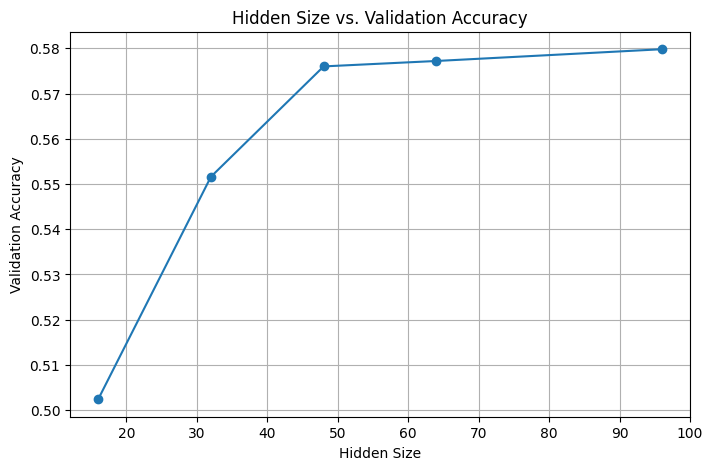

In [ ]:
# Different hidden sizes to experiment with.
hidden_sizes = [16, 32, 48, 64, 96]

# Store validation accuracies for each hidden size.
val_accuracies = []

for hidden_size in hidden_sizes:
    print(f"Training with hidden_size = {hidden_size}")

    # Update the configuration for the current hidden size and the patch size.
    config["patch_size"] = 4 # Use 4 as best patch size found above.
    config["hidden_size"] = hidden_size
    config["intermediate_size"] = 4 * hidden_size  # Ensure intermediate size scales with hidden size.
    config["num_attention_heads"] = max(1, hidden_size // 16)  # Adjust attention heads for valid division.

    # Create a new model with the updated configuration, optimizer, learning rate, loss function, and a trainer instance.
    model = VisionTransformer(config)
    optimizer = torch.optim.AdamW(model.parameters(), lr=best_learning_rate)
    loss_fn = torch.nn.CrossEntropyLoss()

    # Print total trainable params.
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total trainable parameters: {total_params}")

    # Initialize trainer.
    trainer = Trainer(model, optimizer, loss_fn, device)

    # Start timer.
    start_time = time.time()

    # Train the model and evaluate validation accuracy.
    _, _, accuracies = trainer.train(train_loader, val_loader, epochs=5)
    val_accuracies.append(accuracies[-1])  # Record the last validation accuracy.

    # Calculate and print total ttraining time.
    total_time = time.time() - start_time
    print(f"Total training time: {total_time:.2f} seconds")

# Plot validation accuracy vs. hidden size.
plt.figure(figsize=(8, 5))
plt.plot(hidden_sizes, val_accuracies, marker='o')
plt.title("Hidden Size vs. Validation Accuracy")
plt.xlabel("Hidden Size")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.show()

## Experiment with Number of Hidden Layers

The number of transformer layers (hidden layers) defines the depth of the model. More layers may increase the model’s capacity but could lead to overfitting or vanishing gradients.

Using the best learning rate, best patch size, and the best hidden size from the previous experiments, we now experiment with different number of hidden layers in the Vision Transformer. The number of hidden layers determines the depth of the transformer encoder and affects both the model's capacity and training time.

Training with num_hidden_layers = 2
Total trainable parameters: 62554
Epoch 1/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 49.99batch/s]


Train Loss: 1.7928, Validation Loss: 1.6023, Validation Accuracy: 0.4120
Epoch 2/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 49.29batch/s]


Train Loss: 1.4730, Validation Loss: 1.4344, Validation Accuracy: 0.4780
Epoch 3/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 50.69batch/s]


Train Loss: 1.3353, Validation Loss: 1.3525, Validation Accuracy: 0.5130
Epoch 4/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 50.83batch/s]


Train Loss: 1.2454, Validation Loss: 1.2657, Validation Accuracy: 0.5398
Epoch 5/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 50.21batch/s]


Train Loss: 1.1874, Validation Loss: 1.2225, Validation Accuracy: 0.5508
Total training time: 133.57 seconds
Training with num_hidden_layers = 4
Total trainable parameters: 119098
Epoch 1/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 42.36batch/s]


Train Loss: 1.7845, Validation Loss: 1.6670, Validation Accuracy: 0.3584
Epoch 2/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 42.30batch/s]


Train Loss: 1.4486, Validation Loss: 1.3634, Validation Accuracy: 0.5038
Epoch 3/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 41.85batch/s]


Train Loss: 1.2989, Validation Loss: 1.2602, Validation Accuracy: 0.5378
Epoch 4/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 41.41batch/s]


Train Loss: 1.1984, Validation Loss: 1.2478, Validation Accuracy: 0.5570
Epoch 5/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 42.31batch/s]


Train Loss: 1.1249, Validation Loss: 1.1207, Validation Accuracy: 0.5924
Total training time: 192.11 seconds
Training with num_hidden_layers = 6
Total trainable parameters: 175642
Epoch 1/5


Validating: 100%|██████████| 79/79 [00:02<00:00, 36.65batch/s]


Train Loss: 1.8072, Validation Loss: 1.6152, Validation Accuracy: 0.3920
Epoch 2/5


Validating: 100%|██████████| 79/79 [00:02<00:00, 36.99batch/s]


Train Loss: 1.4359, Validation Loss: 1.4625, Validation Accuracy: 0.4676
Epoch 3/5


Validating: 100%|██████████| 79/79 [00:02<00:00, 36.51batch/s]


Train Loss: 1.2715, Validation Loss: 1.2236, Validation Accuracy: 0.5522
Epoch 4/5


Validating: 100%|██████████| 79/79 [00:02<00:00, 36.21batch/s]


Train Loss: 1.1799, Validation Loss: 1.1590, Validation Accuracy: 0.5756
Epoch 5/5


Validating: 100%|██████████| 79/79 [00:02<00:00, 36.74batch/s]


Train Loss: 1.1033, Validation Loss: 1.0856, Validation Accuracy: 0.6086
Total training time: 248.75 seconds


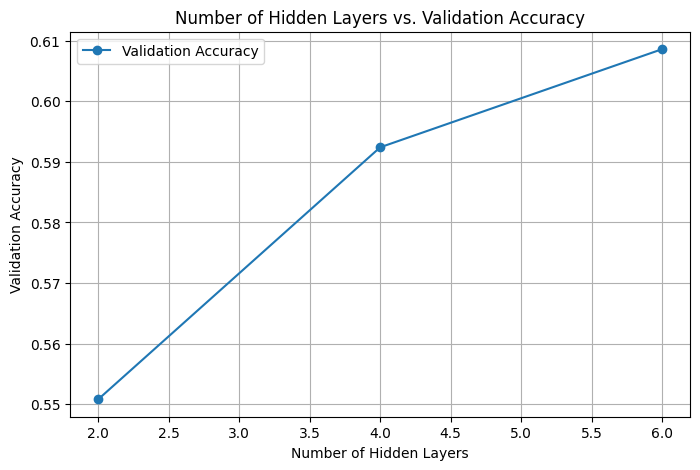

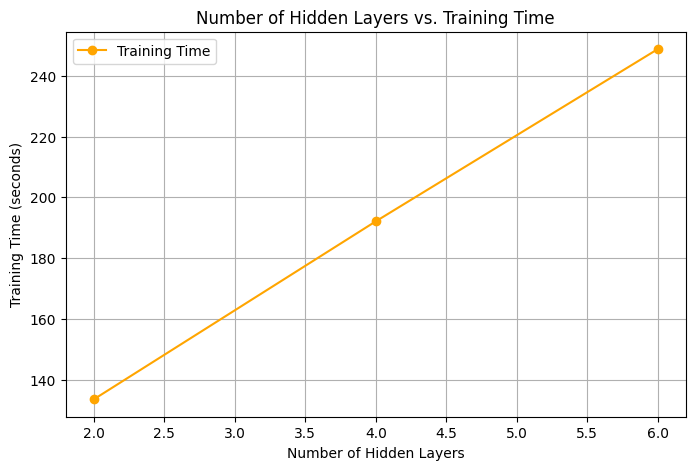

In [ ]:
import time

# Define the list of hidden layer configurations to experiment with.
num_hidden_layers_list = [2, 4, 6]  # Different numbers of hidden layers to try.
val_accuracies = []  # Store validation accuracies for each configuration.
training_times = []  # Store training times for each configuration.

# Iterate over each number of hidden layers.
for num_hidden_layers in num_hidden_layers_list:
    print(f"Training with num_hidden_layers = {num_hidden_layers}")

    # Update the `num_hidden_layers`, optimal `hidden_size` and `patch size` in the `config` dictionary.
    config["num_hidden_layers"] = num_hidden_layers
    config["hidden_size"] = 48 # optimal value found above
    config["intermediate_size"] = 4 * config["hidden_size"]
    config["patch_size"] = 4

    # Create a new VisionTransformer model, optimizer, and loss function.
    model = VisionTransformer(config)
    optimizer = torch.optim.AdamW(model.parameters(), lr=best_learning_rate)
    loss_fn = torch.nn.CrossEntropyLoss()

    # Print total trainable params.
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total trainable parameters: {total_params}")

    # Instantiate the trainer
    trainer = Trainer(model, optimizer, loss_fn, device)

    # Train the model for 5 epochs and record the training time.
    start_time = time.time()
    train_losses, val_losses, accuracies = trainer.train(train_loader, val_loader, epochs=5)
    end_time = time.time()

    # Print the total training time.
    print(f"Total training time: {end_time - start_time:.2f} seconds")

    # Record the last validation accuracy and training time: append the final validation accuracy and training time to the lists.
    val_accuracies.append(accuracies[-1])
    training_times.append(end_time - start_time)

# Plot validation accuracy vs. number of hidden layers.
plt.figure(figsize=(8, 5))
plt.plot(num_hidden_layers_list, val_accuracies, marker='o', label="Validation Accuracy")
plt.title("Number of Hidden Layers vs. Validation Accuracy")
plt.xlabel("Number of Hidden Layers")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.legend()
plt.show()

# Plot training time vs. number of hidden layers.
plt.figure(figsize=(8, 5))
plt.plot(num_hidden_layers_list, training_times, marker='o', color="orange", label="Training Time")
plt.title("Number of Hidden Layers vs. Training Time")
plt.xlabel("Number of Hidden Layers")
plt.ylabel("Training Time (seconds)")
plt.grid(True)
plt.legend()
plt.show()

The plots above illustrate the trade-off between the number of hidden layers in the Vision Transformer and two key metrics: validation accuracy and training time.

1.	What trends can be observed in the relationship between the number of hidden layers, validation accuracy, and training time?
	-	Validation Accuracy: The validation accuracy increases as the number of hidden layers increases, indicating that deeper models capture more complex patterns and relationships in the data.
	-	Training Time: Training time also increases linearly with the number of hidden layers, as each additional layer introduces more parameters and computations.

2.	Why the validation accuracy increases with the number of hidden layers? What are the potential limitations of continuously increasing the number of layers?
	-	Deeper models typically have more representational capacity, allowing them to model complex relationships in the data more effectively.
	-	Each additional layer allows for hierarchical feature extraction, where deeper layers learn increasingly abstract representations.

	Potential Limitations:
	-	Diminishing Returns: At some point, adding more layers may not significantly improve accuracy, as the model’s capacity could exceed what is required for the task.
	-	Overfitting: A very deep model might overfit the training data, especially with limited data, leading to reduced generalization on the validation or test set.
	-	Training Stability: Deeper models are harder to train due to issues like vanishing gradients or optimization difficulties.

3.	Deciding the Optimal Number of Hidden Layers:
	-	The optimal number of layers depends on the trade-off between performance (accuracy) and resource constraints (training time, computational cost).
	-	Look for the point where the validation accuracy starts to plateau relative to the increase in training time.
	-	Practical applications might prioritize faster training/inference over marginal improvements in accuracy, especially for real-time tasks or resource-constrained environments.

## Experiment with Number of Attention Heads

The number of attention heads affects how the model learns to focus on different parts of the sequence (how the model distributes attention across the input sequence). More heads allow more granular attention patterns but may not scale well with smaller hidden sizes.

Using the best learning rate, best patch size, and the best hidden size and number of hidden layers from the previous experiments, now we experiment with different number of attention heads in the Vision Transformer.

Training with num_attention_heads = 2
Total trainable parameters: 119098
Epoch 1/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 51.02batch/s]


Train Loss: 1.8169, Validation Loss: 1.6522, Validation Accuracy: 0.3852
Epoch 2/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 50.70batch/s]


Train Loss: 1.5141, Validation Loss: 1.4881, Validation Accuracy: 0.4588
Epoch 3/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 50.83batch/s]


Train Loss: 1.3598, Validation Loss: 1.3021, Validation Accuracy: 0.5196
Epoch 4/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 49.82batch/s]


Train Loss: 1.2623, Validation Loss: 1.2421, Validation Accuracy: 0.5472
Epoch 5/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 50.28batch/s]


Train Loss: 1.1803, Validation Loss: 1.1726, Validation Accuracy: 0.5716
Total training time: 125.36 seconds
Training with num_attention_heads = 4
Total trainable parameters: 119098
Epoch 1/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 45.30batch/s]


Train Loss: 1.7924, Validation Loss: 1.6379, Validation Accuracy: 0.3990
Epoch 2/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 44.28batch/s]


Train Loss: 1.4612, Validation Loss: 1.3783, Validation Accuracy: 0.5028
Epoch 3/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 46.18batch/s]


Train Loss: 1.3177, Validation Loss: 1.2513, Validation Accuracy: 0.5402
Epoch 4/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 45.96batch/s]


Train Loss: 1.2279, Validation Loss: 1.2501, Validation Accuracy: 0.5384
Epoch 5/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 46.28batch/s]


Train Loss: 1.1602, Validation Loss: 1.1548, Validation Accuracy: 0.5852
Total training time: 157.18 seconds
Training with num_attention_heads = 8
Total trainable parameters: 119098
Epoch 1/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 40.25batch/s]


Train Loss: 1.7262, Validation Loss: 1.5922, Validation Accuracy: 0.4018
Epoch 2/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 39.56batch/s]


Train Loss: 1.3811, Validation Loss: 1.2886, Validation Accuracy: 0.5260
Epoch 3/5


Validating: 100%|██████████| 79/79 [00:02<00:00, 39.40batch/s]


Train Loss: 1.2378, Validation Loss: 1.2016, Validation Accuracy: 0.5636
Epoch 4/5


Validating: 100%|██████████| 79/79 [00:02<00:00, 39.08batch/s]


Train Loss: 1.1573, Validation Loss: 1.1402, Validation Accuracy: 0.5908
Epoch 5/5


Validating: 100%|██████████| 79/79 [00:01<00:00, 39.95batch/s]


Train Loss: 1.0899, Validation Loss: 1.1406, Validation Accuracy: 0.5944
Total training time: 219.33 seconds


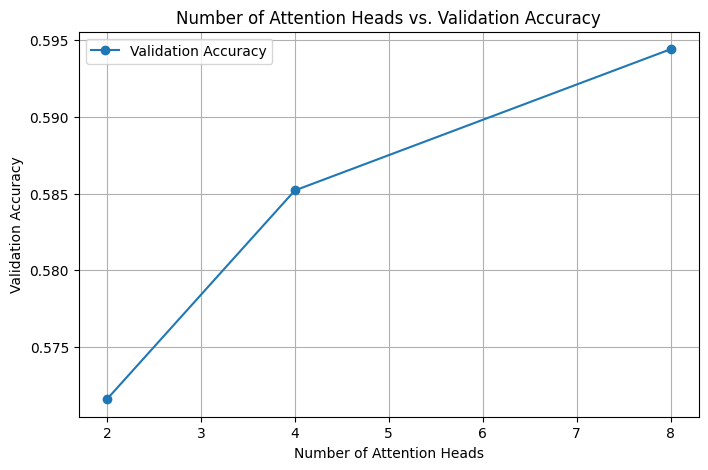

In [ ]:
# Define the list of attention head configurations to experiment with.
num_attention_heads_list = [2, 4, 8]  # Different numbers of attention heads to try.
val_accuracies = []  # Store validation accuracies for each configuration.

# Iterate over each number of attention heads.
for num_attention_heads in num_attention_heads_list:
    print(f"Training with num_attention_heads = {num_attention_heads}")

    # Update the `num_attention_heads`, optimal `hidden_size`, `patch size` and num_hidden_layers in the `config` dictionary.
    config["num_attention_heads"] = num_attention_heads
    config["hidden_size"] = 48
    config["intermediate_size"] = 4 * config["hidden_size"]
    config["patch_size"] = 4
    config["num_hidden_layers"] = 4

    # Ensure that the hidden size is divisible by the number of attention heads.
    assert config["hidden_size"] % config["num_attention_heads"] == 0, \
        "hidden_size must be divisible by num_attention_heads"

    # Create a new VisionTransformer model, optimizer, and loss function.
    model = VisionTransformer(config)
    optimizer = torch.optim.AdamW(model.parameters(), lr=best_learning_rate)
    loss_fn = torch.nn.CrossEntropyLoss()

    # Print total trainable params.
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total trainable parameters: {total_params}")

    # Instantiate the trainer.
    trainer = Trainer(model, optimizer, loss_fn, device)

    # Start timer.
    start_time = time.time()

    # Train the model for 5 epochs and record the final validation accuracy.
    _, _, accuracies = trainer.train(train_loader, val_loader, epochs=5)
    val_accuracies.append(accuracies[-1])

    # Calculate and print the total training time.
    end_time = time.time()
    print(f"Total training time: {end_time - start_time:.2f} seconds")

# Plot validation accuracy vs. number of attention heads.
plt.figure(figsize=(8, 5))
plt.plot(num_attention_heads_list, val_accuracies, marker='o', label="Validation Accuracy")
plt.title("Number of Attention Heads vs. Validation Accuracy")
plt.xlabel("Number of Attention Heads")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.legend()
plt.show()

## Visualize Attention Maps

Attention maps are a key feature of Vision Transformers, as they help us understand which parts of an image the model is focusing on while making predictions.

These maps represent how much “attention” the model is paying to different image regions.

By visualizing attention maps, we can gain insights into the interpretability of the model and verify if it is focusing on relevant parts of the image.

In [ ]:
def visualize_attention_maps(model, dataloader, num_per_class=2):
    """
    Visualize attention maps for `num_per_class` images per class.

    Parameters:
    - model: Trained Vision Transformer model.
    - dataloader: DataLoader for the dataset.
    - num_per_class: Number of images to visualize per class.
    """
    model.eval()  # Set the model to evaluation mode.
    images_per_class = {i: 0 for i in range(10)}  # Track images per class.
    images, attention_maps, classes = [], [], []

    with torch.no_grad():
        for images_batch, labels_batch in dataloader:
            images_batch, labels_batch = images_batch.to(device), labels_batch.to(device)

            # Forward pass through the model and extract attention maps.
            _, attentions = model(images_batch, output_attentions=True) # attentions of shape (batch_size, num_heads, sequence_length, sequence_length).

            # Attentions is a list of attentions of all layers: extract attention maps from the last layer.
            attentions = attentions[-1] # (batch_size, num_heads, sequence_length, sequence_length).

            # Make the shape of (batch_size, sequence_length, sequence_length) by averaging across heads.
            attentions = torch.mean(attentions, dim=1) # (batch_size, sequence_length, sequence_length).

            # Remove cls token.
            attentions_without_cls = attentions[:, 0, 1:] # (batch_size, sequence_length-1).

            # We actually have (batch_size, attention score in a vector of (image_size/patch_size)**2 - 1 =64). To visualize we need to reshape in a form of (batch_size, size, size), where size=8 because 8*8=64.
            size = model.config["image_size"] // model.config["patch_size"]
            attentions_without_cls = attentions_without_cls.reshape(-1, size, size)

            # Select `num_per_class` images and attention maps for visualization.
            for img, attn_map, label in zip(images_batch, attentions_without_cls, labels_batch):
                if images_per_class[label.item()] < num_per_class:
                  # To use mataplotlib, we need to move to cpu.
                  images.append(img.cpu())
                  attention_maps.append(attn_map.cpu())
                  classes.append(label.item())
                  images_per_class[label.item()] += 1 # we will select num_per_class in total.

                # If we gather num_per_class images, we go to the next class.
                if all(count == num_per_class for count in images_per_class.values()):
                    break

    # Normalize attention maps to [0, 1].
    attention_maps = [am / am.max() for am in attention_maps]

    # Define grid for visualization: 10 rows (classes) and 2 columns per image.
    num_rows = 10
    num_cols = num_per_class * 2

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))

    for idx, (image, attn_map, cls) in enumerate(zip(images, attention_maps, classes)):
        row = cls
        col = (idx % num_per_class) * 2

        # Visualize the original image.
        img = image.permute(1, 2, 0)  # Convert (C, H, W) to (H, W, C).
        img = (img * 0.5 + 0.5).clamp(0, 1).numpy()  # De-normalize and clip to [0, 1].
        axs[row, col].imshow(img)
        axs[row, col].axis("off")
        axs[row, col].set_title(cifar10_classes[cls])  # Display class name.

        # Visualize the attention map.
        axs[row, col + 1].imshow(attn_map, cmap="cividis")  # Purple-yellow colormap.
        axs[row, col + 1].axis("off")
        axs[row, col + 1].set_title("Attention Map")

    plt.tight_layout()
    plt.show()

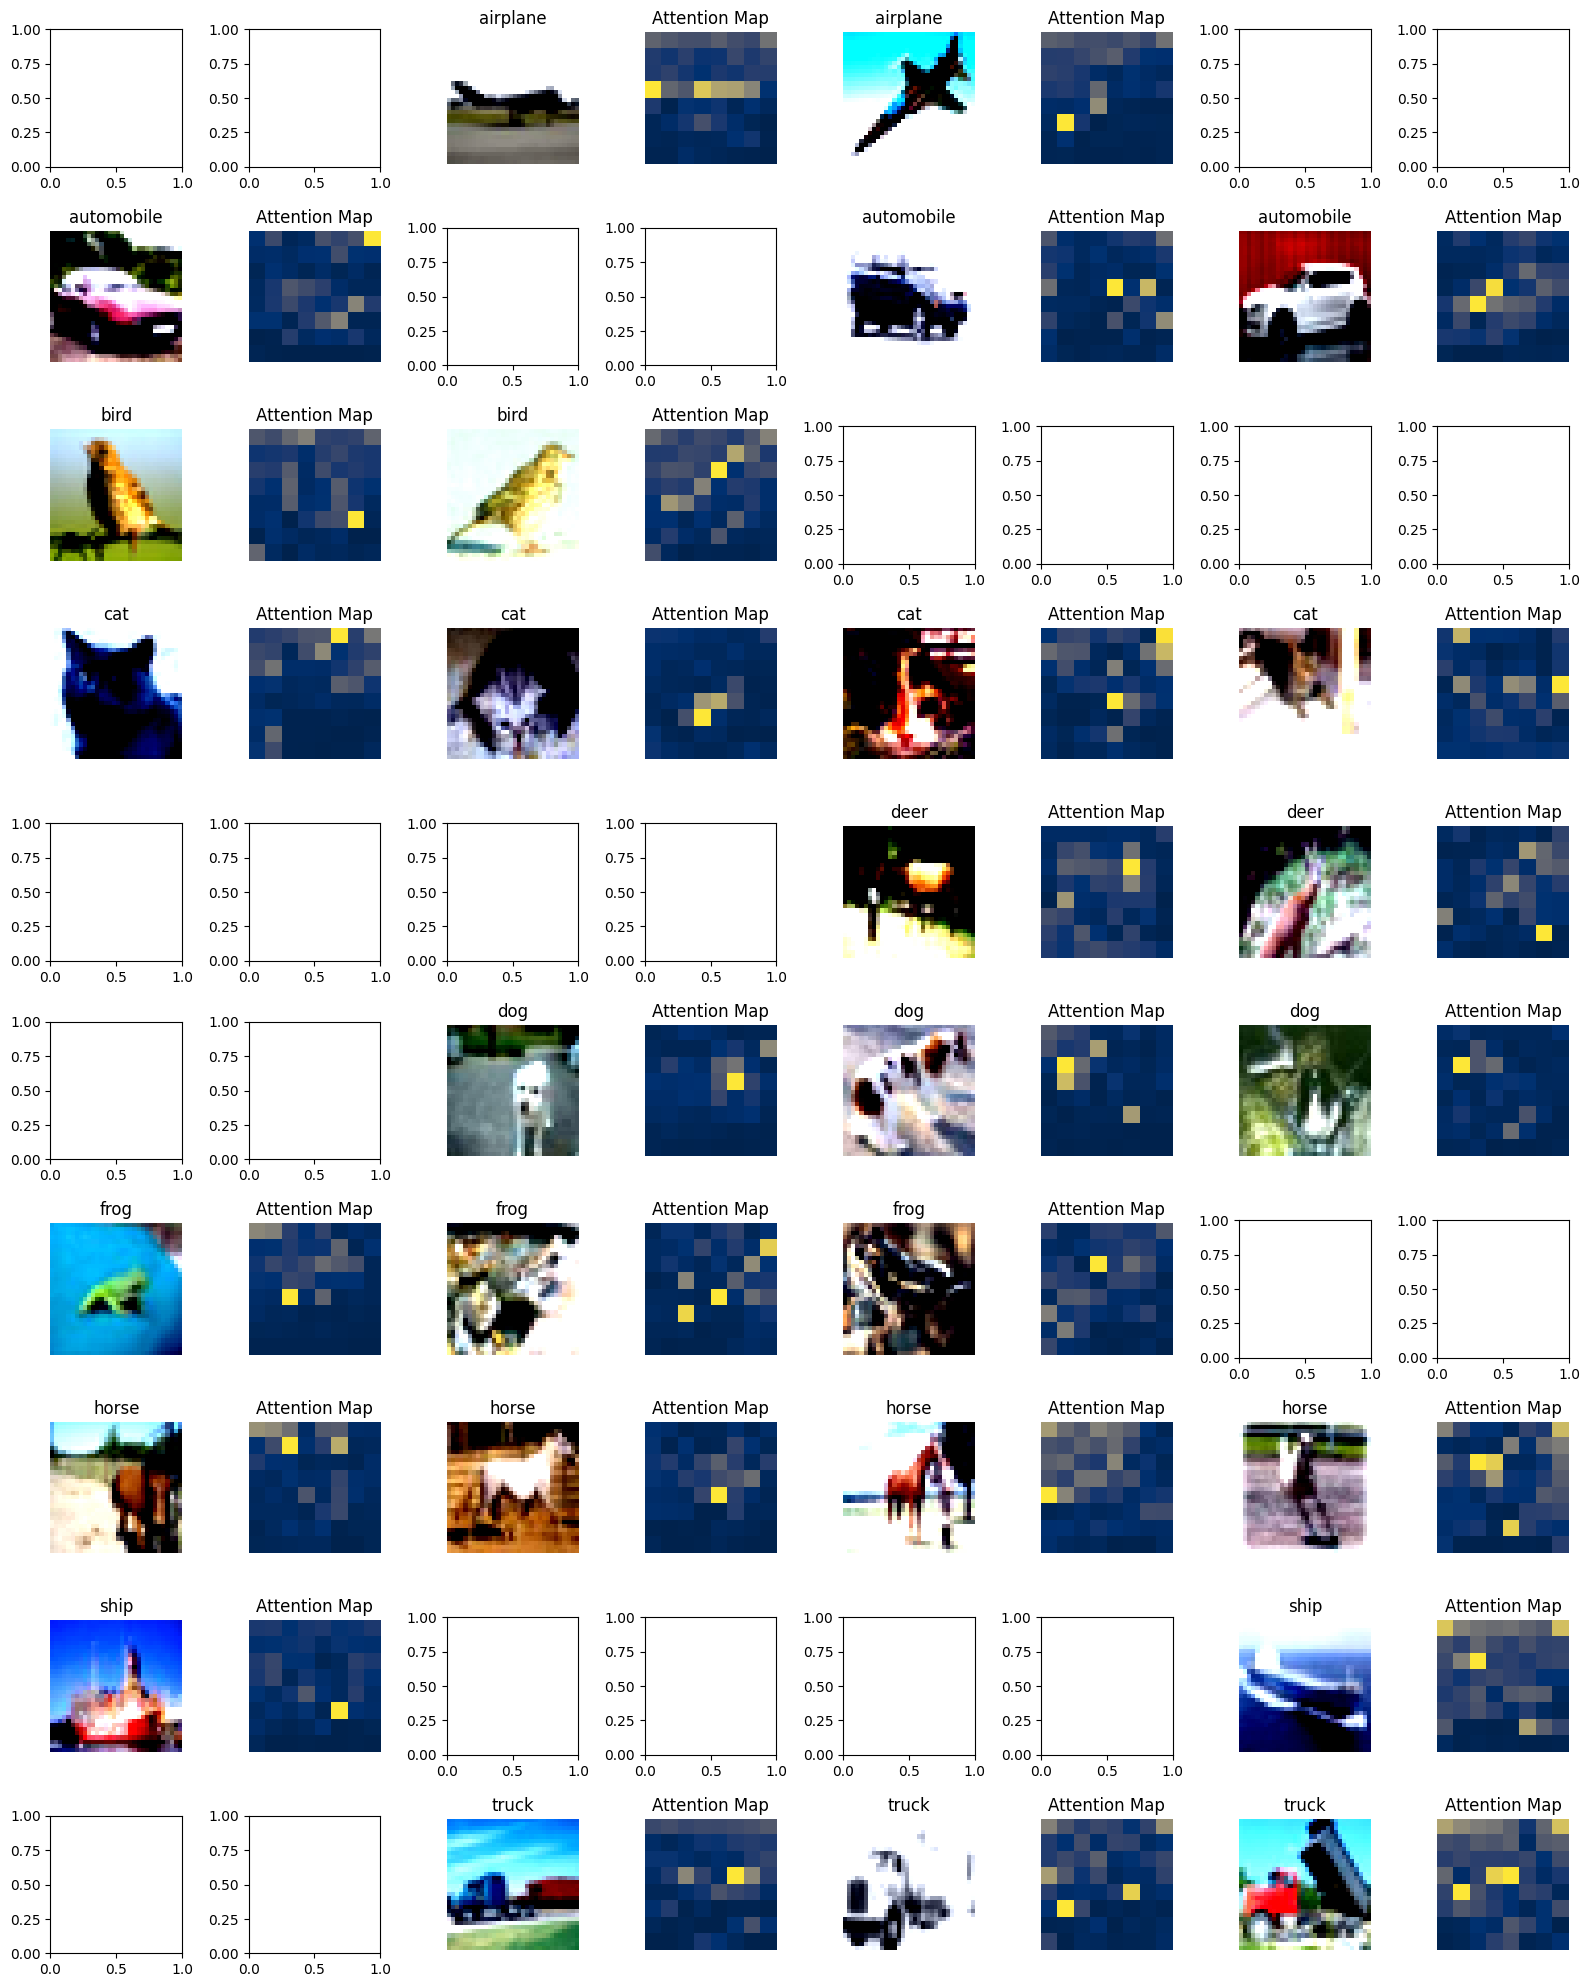

In [ ]:
# Pass the validation DataLoader to visualize attention maps.
visualize_attention_maps(model, val_loader, num_per_class=4)

Advanced data augmentation (e.g., CutMix, MixUp, RandAugment) can improve generalization and make the model more robust to variations in the input data.

# Fine-tune a pre-trained ViT-Tiny (ViT-T/16)

Fine-tuning a pre-trained Vision Transformer (ViT) involves taking a model that has already been trained on a large dataset (e.g., ImageNet-1k) and adapting it to a new, smaller dataset (e.g., CIFAR-10).

The benefit is that the model already has learned features that can be fine-tuned to the new task, saving time and computational resources compared to training from scratch.

## Install `timm` library

`timm` is a PyTorch library that provides access to state-of-the-art pre-trained models, including Vision Transformers. We need to install it before importing the pre-trained ViT-Tiny.

In [ ]:
!pip install timm

### Modify `Trainer`

We have to slightly modify our `Trainer`:

In [ ]:
class Trainer:
    def __init__(self, model, optimizer, loss_fn, device):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.device = device

    def train_epoch(self, train_loader):
        """
        Train the model for one epoch with a progress bar.
        """
        self.model.train()
        total_loss = 0

        # Initialize tqdm progress bar.
        with tqdm(train_loader, desc="Training", unit="batch") as t:
            for images, labels in t:
                images, labels = images.to(self.device), labels.to(self.device)

                # Zero gradients.
                self.optimizer.zero_grad()

                # Forward pass.
                logits = self.model(images)

                # Compute loss.
                loss = self.loss_fn(logits, labels)

                # Backward pass.
                loss.backward()

                # Update parameters.
                self.optimizer.step()

                # Accumulate loss.
                total_loss += loss.item() * len(images)

                # Update progress bar.
                t.set_postfix(loss=loss.item())

        # Average loss.
        return total_loss / len(train_loader.dataset)

    @torch.no_grad()
    def evaluate(self, dataloader):
        """
        Evaluate the model on the given dataloader with a progress bar.
        """
        self.model.eval()
        total_loss = 0
        correct = 0

        # Initialize tqdm progress bar.
        with tqdm(dataloader, desc="Validating", unit="batch") as t:
            for images, labels in t:
                images, labels = images.to(self.device), labels.to(self.device)

                # Forward pass.
                logits = self.model(images)

                # Compute loss.
                loss = self.loss_fn(logits, labels)
                total_loss += loss.item() * len(images)

                # Compute accuracy.
                predictions = torch.argmax(logits, dim=1)
                correct += (predictions == labels).sum().item()

        accuracy = correct / len(dataloader.dataset)
        avg_loss = total_loss / len(dataloader.dataset)

        return accuracy, avg_loss

    def train(self, train_loader, val_loader, epochs):
        """
        Train the model for the specified number of epochs.
        """
        train_losses, val_losses, accuracies = [], [], []

        for epoch in range(epochs):
            print(f"Epoch {epoch + 1}/{epochs}")

            # Train for one epoch.
            train_loss = self.train_epoch(train_loader)

            # Evaluate on the val set.
            accuracy, val_loss = self.evaluate(val_loader)

            # Record metrics.
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            accuracies.append(accuracy)

            # Print epoch metrics.
            print(f"Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.4f}")

        # Return the training history.
        return train_losses, val_losses, accuracies

## Implementation

### Key steps:

1.	Preprocessing the CIFAR-10 Dataset:
	-	CIFAR-10 images are  32 $\times$ 32 , while the pre-trained ViT-Tiny expects images of  224 $\times$ 224 . We resize the images during preprocessing.
	-	Normalization is applied using the CIFAR-10 dataset’s mean and standard deviation.
2.	Loading the Pre-trained ViT-Tiny Model:
	-	The model is loaded with pre-trained weights on ImageNet-1k.
	-	The classifier head is modified to match the number of classes in CIFAR-10 (10 classes).
3.	Fine-tuning the Model:
	-	The model’s parameters are fine-tuned on the CIFAR-10 dataset using the AdamW optimizer and cross-entropy loss.
	-	Training is performed for 5 epochs, and validation accuracy is recorded after each epoch.
4.	Plotting Validation Accuracy:
	-	A plot is created to show how validation accuracy evolves over epochs.

Loading CIFAR-10 dataset...
Files already downloaded and verified
Files already downloaded and verified
Loading pre-trained ViT-Tiny model...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Total number of trainable parameters: 5526346
Starting fine-tuning...
Epoch 1/5


Validating: 100%|██████████| 79/79 [00:08<00:00,  9.71batch/s]


Train Loss: 0.3114, Validation Loss: 0.2338, Validation Accuracy: 0.9210
Epoch 2/5


Validating: 100%|██████████| 79/79 [00:08<00:00,  9.61batch/s]


Train Loss: 0.1521, Validation Loss: 0.2458, Validation Accuracy: 0.9222
Epoch 3/5


Validating: 100%|██████████| 79/79 [00:08<00:00,  9.67batch/s]


Train Loss: 0.1123, Validation Loss: 0.2108, Validation Accuracy: 0.9322
Epoch 4/5


Validating: 100%|██████████| 79/79 [00:08<00:00,  9.55batch/s]


Train Loss: 0.0924, Validation Loss: 0.2307, Validation Accuracy: 0.9278
Epoch 5/5


Validating: 100%|██████████| 79/79 [00:08<00:00,  9.60batch/s]


Train Loss: 0.0827, Validation Loss: 0.2213, Validation Accuracy: 0.9320
Total training time: 520.70 seconds


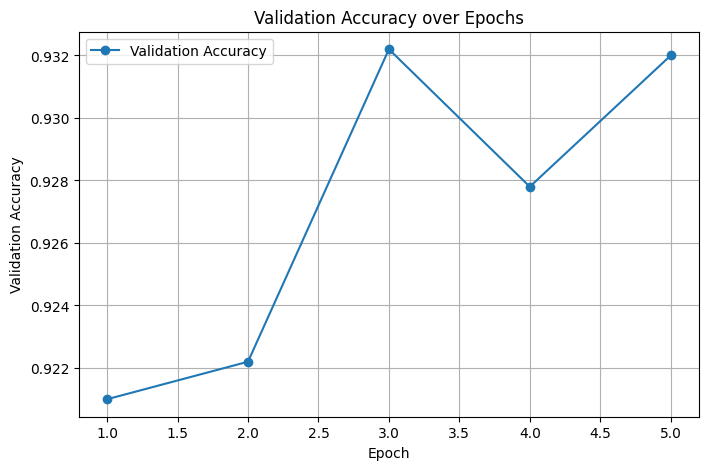

In [ ]:
# Import necessary libraries.
from timm import create_model
from torch.utils.data import DataLoader, random_split


# Define the mean and standard deviation for CIFAR-10.
mean = (0.4914, 0.4822, 0.4465)  # Precomputed mean for CIFAR-10.
std = (0.2023, 0.1994, 0.2010)   # Precomputed std for CIFAR-10.

# Define dataset path
dataset_path = '/content/drive/MyDrive/'

# Define the transform for resizing CIFAR-10: images to 224x224, including normalization using the provided `mean` and `std`.
transform_resized = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Use the same number of images for train, val, and test splits.
num_train = 45000  # Number of training examples.
num_val = 5000    # Number of validation examples.
num_test = 10000   # Number of test examples (CIFAR-10 test set size).

# Use the `transform_resized` defined above to preprocess the CIFAR-10 dataset and the splits defined above to define all the subsets with the resized images.
print("Loading CIFAR-10 dataset...")
dataset = datasets.CIFAR10(root=dataset_path, train=True, download=True, transform=transform_resized)
train_dataset, val_dataset = random_split(dataset, [num_train, num_val])
test_dataset = datasets.CIFAR10(root=dataset_path, train=False, download=True, transform=transform_resized)

# Use the same batch size as before.
batch_size = 64

# Define DataLoaders for the training and validation resized datasets.
train_loader_resized = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader_resized = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader_resized = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# print(f"Training set size: {len(train_dataset)}")
# print(f"Validation set size: {len(val_dataset)}")
# print(f"Test set size: {len(test_dataset)}")

# Load the pre-trained ViT-Tiny model from timm.
print("Loading pre-trained ViT-Tiny model...")
model = create_model(
    "vit_tiny_patch16_224",  # Pre-trained ViT-Tiny on ImageNet-1k.
    pretrained=True,        # Load pre-trained weights.
    num_classes=10          # Adapt classifier head to CIFAR-10 (10 classes).
)

# Print the total number of trainable parameters.
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")

# Define optimizer and loss function.
optimizer = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-2)
loss_fn = nn.CrossEntropyLoss()

# Start the timer to calculate the total training time.
start_time = time.time()

# Instantiate the trainer
trainer = Trainer(model, optimizer, loss_fn, device)

# Train the model for 5 epochs.
print("Starting fine-tuning...")
train_losses, val_losses, accuracies = trainer.train(train_loader_resized, val_loader_resized, epochs=5)

# Calculate and print the total training time.
total_time = time.time() - start_time
print(f"Total training time: {total_time:.2f} seconds")

# Plot validation accuracy over epochs.
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o', label="Validation Accuracy")
plt.title("Validation Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.legend()
plt.show()

# Fine-tune only the classifier of a ViT-Tiny (ViT-T/16)

Now, we will leverage the same pre-trained model from the `timm` library, but instead of fine-tuning the entire model, we freeze all layers except the classifier head.

This approach is computationally efficient and allows us to adapt the powerful features learned during pre-training to our target dataset, CIFAR-10.

## Implementation

### Key steps:

1.	**Loading the Pre-trained Model**: We load the ViT-T/16 model pre-trained on ImageNet-1k and modify its classifier head to handle CIFAR-10’s 10 classes.
2.	**Freezing Layers**: All layers are frozen except the classifier. This ensures that the pre-trained feature extractor is not altered during training.
3.	**Fine-tuning the Classifier**: The optimizer is applied only to the classifier, reducing training complexity and time.

Total number of trainable parameters: 1930
Epoch 1/5


Validating: 100%|██████████| 79/79 [00:08<00:00,  9.64batch/s]


Train Loss: 1.1348, Validation Loss: 0.8354, Validation Accuracy: 0.7150
Epoch 2/5


Validating: 100%|██████████| 79/79 [00:08<00:00,  9.65batch/s]


Train Loss: 0.7868, Validation Loss: 0.7533, Validation Accuracy: 0.7376
Epoch 3/5


Validating: 100%|██████████| 79/79 [00:08<00:00,  9.53batch/s]


Train Loss: 0.7313, Validation Loss: 0.7255, Validation Accuracy: 0.7500
Epoch 4/5


Validating: 100%|██████████| 79/79 [00:08<00:00,  9.41batch/s]


Train Loss: 0.7041, Validation Loss: 0.7068, Validation Accuracy: 0.7548
Epoch 5/5


Validating: 100%|██████████| 79/79 [00:08<00:00,  9.53batch/s]


Train Loss: 0.6875, Validation Loss: 0.6981, Validation Accuracy: 0.7596
Total training time: 421.29 seconds


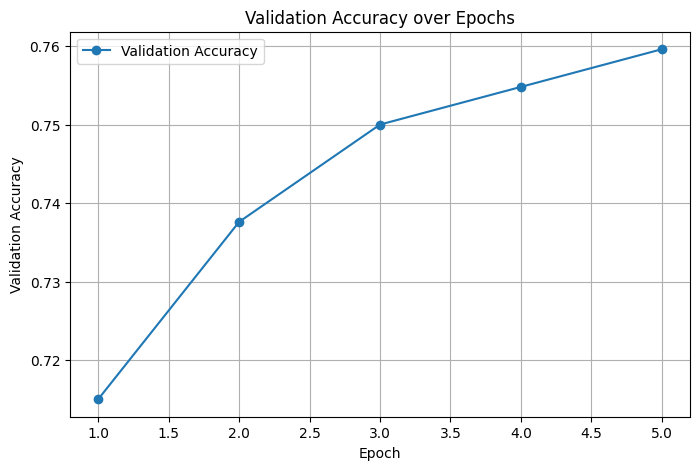

In [ ]:
# Load a pre-trained ViT-T/16 model (Same as above: only keep the head trainable).
model = create_model(
    "vit_tiny_patch16_224",
    pretrained=True,
    num_classes=10
)

# Freeze all layers except the classifier.
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the classifier layer.
for param in model.head.parameters():
    param.requires_grad = True

# Print the total number of trainable params.
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")

# Define the AdamW optimizer and cross-entropy loss function and only pass the head/classifier parameters to the optimizer.
optimizer = optim.AdamW(model.head.parameters(), lr=2e-4, weight_decay=1e-2)
loss_fn = nn.CrossEntropyLoss()

# Start timer.
start_time = time.time()

# Instantiate the trainer.
trainer = Trainer(model, optimizer, loss_fn, device)

# Train the model for 5 epochs.
train_losses, val_losses, accuracies = trainer.train(train_loader_resized, val_loader_resized, epochs=5)

# Calculate and print the total training time.
total_time = time.time() - start_time
print(f"Total training time: {total_time:.2f} seconds")

# Plot validation accuracy over epochs.
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o', label="Validation Accuracy")
plt.title("Validation Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.legend()
plt.show()

# Fine-tune only the classifier of a ViT-Base (ViT-B/16)

Now, we will leverage a larger pre-trained model, the ViT-B/16 from the `timm` library, which has been trained on ImageNet-1k.

We will freeze all layers except the classifier head. We will again fine-tune only the classifier.

As we've said, this approach is computationally efficient and allows us to adapt the powerful features learned during pre-training to our target dataset, CIFAR-10.

## Implementation

### Key steps:

1.	**Loading the Pre-trained Model**: We load the ViT-B/16 model pre-trained on ImageNet-1k and modify its classifier head to handle CIFAR-10’s 10 classes.
2.	**Freezing Layers**: All layers are frozen except the classifier. This ensures that the pre-trained feature extractor is not altered during training.
3.	**Fine-tuning the Classifier**: The optimizer is applied only to the classifier, reducing training complexity and time.

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Total number of trainable parameters: 7690
Epoch 1/5


Validating: 100%|██████████| 79/79 [00:16<00:00,  4.69batch/s]


Train Loss: 0.4317, Validation Loss: 0.2453, Validation Accuracy: 0.9242
Epoch 2/5


Validating: 100%|██████████| 79/79 [00:16<00:00,  4.69batch/s]


Train Loss: 0.2030, Validation Loss: 0.2109, Validation Accuracy: 0.9328
Epoch 3/5


Validating: 100%|██████████| 79/79 [00:16<00:00,  4.68batch/s]


Train Loss: 0.1767, Validation Loss: 0.1974, Validation Accuracy: 0.9342
Epoch 4/5


Validating: 100%|██████████| 79/79 [00:16<00:00,  4.67batch/s]


Train Loss: 0.1622, Validation Loss: 0.1949, Validation Accuracy: 0.9364
Epoch 5/5


Validating: 100%|██████████| 79/79 [00:16<00:00,  4.68batch/s]


Train Loss: 0.1528, Validation Loss: 0.1876, Validation Accuracy: 0.9384
Total training time: 848.51 seconds


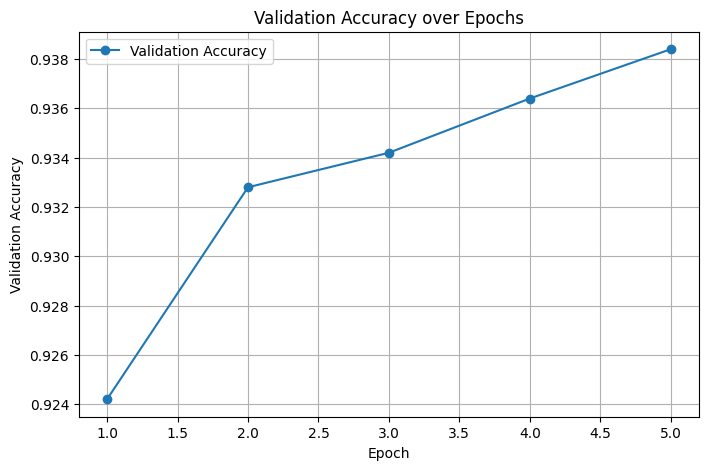

In [ ]:
# Load a pre-trained ViT-B/16 model.
model = create_model(
    "vit_base_patch16_224",
    pretrained=True,
    num_classes=10
)

# Freeze all layers except the classifier.
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the classifier layer.
for param in model.head.parameters():
    param.requires_grad = True

# Print the total trainable params.
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")

# Define the AdamW optimizer and cross-entropy loss function and pass only the head/classifier parameters to the optimizer.
optimizer = optim.AdamW(model.head.parameters(), lr=2e-4, weight_decay=1e-2)
loss_fn = nn.CrossEntropyLoss()

# Start timer.
start_time = time.time()

# Instantiate the trainer.
trainer = Trainer(model, optimizer, loss_fn, device)

# Train the model for 5 epochs.
train_losses, val_losses, accuracies = trainer.train(train_loader_resized, val_loader_resized, epochs=5)

# Calculate and print the total training time.
total_time = time.time() - start_time
print(f"Total training time: {total_time:.2f} seconds")

# Plot validation accuracy over epochs.
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o', label="Validation Accuracy")
plt.title("Validation Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.legend()
plt.show()

# Evaluate the best model on the test set of CIFAR-10

Having done all these different experiments, evaluating smaller and bigger, custom and well-known models on the validation set, now it is time to evaluate the best model on the the CIFAR-10 test set.

Below we evaluate the fine-tuned (only the classifier) ViT-Base model.

In [ ]:
test_acc, test_loss = trainer.evaluate(test_loader_resized)

Validating: 100%|██████████| 157/157 [00:33<00:00,  4.64batch/s]


In [ ]:
print(f'Accuracy on CIFAR-10 test set: {test_acc*100}%')

Accuracy on CIFAR-10 test set: 94.11%


# Technical Report

The below table shows the results from all the above experiments.

| **Hyperparameter Configuration**        | **Trainable Parameters** | **Training Time (s)** | **Validation Accuracy (%)** |
|------------------------------------------|---------------------------|-----------------------|-----------------------------|
| Patch Size: 2               | 126.586                         | 190.76                     | 59.34                           |
| Patch Size: 4               | 119.098                         | 188.51                     | 57.02                           |
| Patch Size: 8             | 123.706                         | 187.83                     | 51.44                           |
| Hidden Size: 16                         | 15.130                         | 110.35                     | 50.24                           |
| Hidden Size: 32                         | 54.826                         | 125.97                     | 55.16                           |
| Hidden Size: 48                         | 119.098                         | 142.24                     | 57.60                           |
| Hidden Size: 64                         | 207.946                         | 157.96                     | 57.72                           |
| Hidden Size: 96                         | 459.370                         | 189.23                     | 57.98                           |
| Hidden Layer Size: 2                         | 62.554                         | 133.57                     | 55.08                           |
| Hidden Layer Size: 4                         | 119.098                         | 192.11                     | 59.24                           |
| Hidden Layer Size: 6                         | 175.642                         | 248.75                     | 60.86                           |
| Attention Heads: 2                       | 119098                         | 125.36                     | 57.16                           |
| Attention Heads: 4                       | 119098                         | 157.18                     | 58.52                           |
| Attention Heads: 8                       | 119098                         | 219.33                     | 59.44                           |

| Model                   | Training Time (seconds) | Trainable Parameters | Validation Accuracy (%) |
|-------------------------|-------------------------|----------------------|-------------------------|
| Custom ViT (Base Model)   | 219.33                     | 119.098            | 58.52                    |
| ViT-T/16 (Entirely fine-tuned)    | 520.70                     | 5.526.346            | 93.20                    |
| ViT-T/16 (Classifier fine-tuned)                | 421.29                     | 1930           | 75.96                    |
| ViT-B/16 (Classifier fine-tuned)                 | 848.51                     | 7690           | 93.84                    |


Custom Vision Transformer

Impact of Hyperparameters:

Patch Size: smaller patch sizes improved validation accuracy but increased training time and trainable parameters. Larger patch sizes reduced accuracy and complexity. Our choice was 4 to balance accuracy and complexity with almost the same training time as in best case here(patch size 8)
Hidden Size: increasing hidden size improved accuracy up to a point but significantly increased trainable parameters and training time (e.g., hidden size 96: 57.98% accuracy, but 459k parameters and 189s training time).
Number of Layers: the same pattern we also observe here as validation accuracy improved with more layers, with the best result at 6 layers (60.86%), at the cost of increased training time and complexity. The difference between the accuracy of 4 and 6 hidden layers is not so big taking into account the higher time and trainable parameters, that is why we finally chose 4 as the best size.  
Attention Heads: Increasing attention heads improved accuracy slightly (e.g., 2 heads: 57.16%, 8 heads: 59.44%) but required more time.

Trade-offs:

Higher model complexity (more layers, larger hidden size, smaller patches) generally resulted in better accuracy but increased training time and resource consumption. Increasing attention heads, training time is also increases. So, the task of hyperparameter tuning and the final choice of the values is critical and it depends on what we have to do(e.g. mobile applicattions, research, ..).

Visualization of Attention Maps
Insights:

Attention maps highlighted regions of focus, such as objects and important areas in images.
The model effectively localized key features (e.g., airplane's or car's shape) during classification. Visualizations confirmed how attention layers adapt to different classes and features, demonstrating the effectiveness of the Vision Transformers.

Fine-tuning Pre-trained Vision Transformers

Performance Comparison:

Fine-tuning Entire ViT-Tiny: achieved the second highest validation accuracy (93.20%), but required significant computational resources (5.5M parameters, 520.70s training time).

Fine-tuning Classifier of ViT-Tiny: achieved 75.96% accuracy with only 1930 trainable parameters and much shorter training time, demonstrating the efficiency of this approach.

Training Only Classifier of ViT-Base: achieved the best performance to fine-tune only the ViT Base classifier with more trainable parameters (7690) than the previous case and much higher accuracy (93.84%).

General Observations:

Regarding the validation accuracy, all pre-trained models significantly outperformed our custom Vision Transformer, with ViT-B/16 classifier fine-tuning achieving the best results. Fine-tuning only the classifier of pre-trained models provided a strong balance between accuracy and efficiency.

Regarding the ease of use, our custom ViT offers flexibility in architecture design but requires substantial resources to achieve competitive accuracy in comparison with pre-trained models, which are computationally efficient and offer much higher performance, particularly when fine-tuning is limited to the classifier. So, depending, again, on what we have to do and try, we choose the appropriate workflow.

In conclusion, pre-trained Vision Transformers are more effective for CIFAR-10, offering superior accuracy with fewer trainable parameters and faster training times compared to custom models. Fine-tuning only the classifier layer achieves the best balance between computational efficiency and performance.